# Gramener Case Study 

In [109]:
## Submitted by 
## Aman Srivastava - amanit0812@gmail.com
## Nurul Quamar Khan - noor.025@gmail.com
## Prakash Srinivasan  - Prakash.Srinivasan@techmahindra.com
## Tim Kumar  - timkoumar@gmail.com

In [110]:
####Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

In [111]:
####Load the Dataset and set the datatype of next payment as string
loan = pd.read_csv("loan.csv",dtype={'next_pymnt_d': str})
loan.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


## Data Cleansing

In [112]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [113]:
####Remove all columns that with all null values
master=loan.loc[:, ~(loan.isnull().all())]
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 57 columns):
id                            39717 non-null int64
member_id                     39717 non-null int64
loan_amnt                     39717 non-null int64
funded_amnt                   39717 non-null int64
funded_amnt_inv               39717 non-null float64
term                          39717 non-null object
int_rate                      39717 non-null object
installment                   39717 non-null float64
grade                         39717 non-null object
sub_grade                     39717 non-null object
emp_title                     37259 non-null object
emp_length                    39717 non-null object
home_ownership                39717 non-null object
annual_inc                    39717 non-null float64
verification_status           39717 non-null object
issue_d                       39717 non-null object
loan_status                   39717 non-null object
pymnt_pl

In [114]:
####Remove all columns that has only 1 unique value as it doesn't add any information to our analysis
master=master.loc[:,~(master.nunique()==1)]
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 48 columns):
id                         39717 non-null int64
member_id                  39717 non-null int64
loan_amnt                  39717 non-null int64
funded_amnt                39717 non-null int64
funded_amnt_inv            39717 non-null float64
term                       39717 non-null object
int_rate                   39717 non-null object
installment                39717 non-null float64
grade                      39717 non-null object
sub_grade                  39717 non-null object
emp_title                  37259 non-null object
emp_length                 39717 non-null object
home_ownership             39717 non-null object
annual_inc                 39717 non-null float64
verification_status        39717 non-null object
issue_d                    39717 non-null object
loan_status                39717 non-null object
url                        39717 non-null object
desc      

##### From 111 columns we are down to 48. Lets continue with further cleansing

In [115]:
####Data Cleaning - custom function to remove unwanted characters from a string
def clean(s1):
    s1=s1.lower()
    import re
    pattern=re.compile(r"[-,*.!@|#$+_\'()]")
    res=re.sub(pattern,'',s1)
    res=re.sub(r'\s+','',res) 
    return res

####Clean the emp_title column
master['emp_title_clean']=master['emp_title'].astype(str).apply(lambda x:clean(x))

####Remove "months" from the term column and set the type to float
master['term']=master['term'].apply(lambda x:x.replace(" months","")).astype(float)

####Remove "%" from the int_rate column and set the type to float
master['int_rate']=master['int_rate'].apply(lambda x:x.replace("%","")).astype(float)

####Fill the Nan with % so that it can be removed  
master['revol_util'] = master['revol_util'].fillna('0%')

####Remove "%" from the revol_util column and set the type to float
master['revol_util']=master['revol_util'].apply(lambda x:x.replace("%","")).astype(float)

#### In the Annual Income we see there 2 outliers and identify and replace them with median.
median = master.loc[master['annual_inc']<=2039784, 'annual_inc'].median()
master["annual_inc"] = np.where(master["annual_inc"] >2039784, median,loan['annual_inc'])

master.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies,emp_title_clean
0,1077501,1296599,5000,5000,4975.0,36.0,10.65,162.87,B,B2,...,863.16,0.0,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,nan
1,1077430,1314167,2500,2500,2500.0,60.0,15.27,59.83,C,C4,...,435.17,0.0,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,ryder


##### Now that we have performed basic cleansing we will start analysing the data.

# Univarite Analysis

In [116]:
####Define custom univariate function for differnet types of plots

import collections
####plotInfo hold information about the attribute that is plotted along with alignment params
plotInfo=collections.namedtuple('plotInfo',['attribute','tickerRot','alignment'])

def univariateplot(ptype,info,n=0,df=master):
    """
    ptype-> plot type. Use "dist"-> Distribution , "box" -> Box plot and "count"-> Count plot
    info -> contains list of named tuples "plotInfo" having info on which attribute to plot on.
    n    -> number of sub-plots
    """
    import math
    sub=math.sqrt(n) if n!=2 else 2   
    plt.figure(figsize=(20, 10))
  
    for i in range(n):
        plt.subplot(sub,sub,i+1)
        if i <= (len(info) -1):
            if ptype=="dist":
                sns.distplot(df[info[i].attribute],kde=True)
            elif ptype=="box":
                sns.boxplot(y=df[info[i].attribute])
            elif ptype=="count":
                ax=sns.countplot(df[info[i].attribute])
                ax.set_xticklabels(ax.get_xticklabels(), rotation=info[i].tickerRot, ha=info[i].alignment)
                totalHeight=[]
                for p in ax.patches:
                    height = p.get_height()
                    totalHeight.append(height)
                total=sum(totalHeight)
                for p in ax.patches:
                    height = p.get_height()
                    ax.text(p.get_x()+p.get_width()/2.,height + 3,
                      '{:d}'.format(int(height)),rotation=0,ha="center")        
    plt.show()

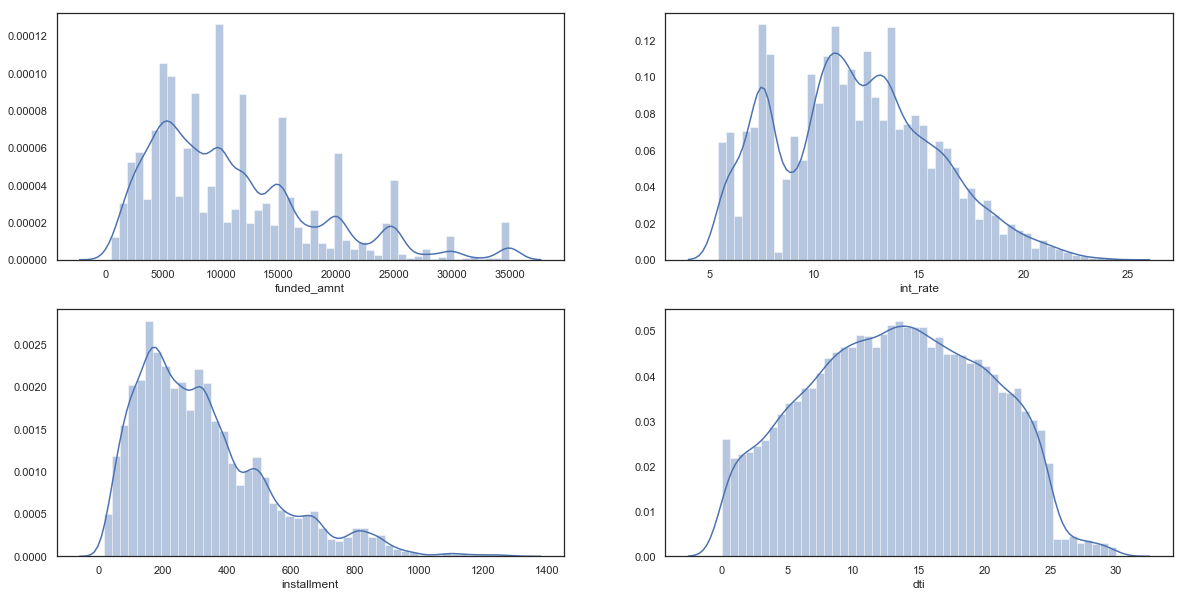

In [117]:
####Univariate Analysis - Histogram on "funded_amnt", "int_rate", "installment", "dti"
p1 = plotInfo("funded_amnt",0,'center')
p2 = plotInfo("int_rate",0,'center')
p3 = plotInfo("installment",0,'center')
p4 = plotInfo("dti",0,'center')
univariateplot("dist",[p1,p2,p3,p4],n=4)

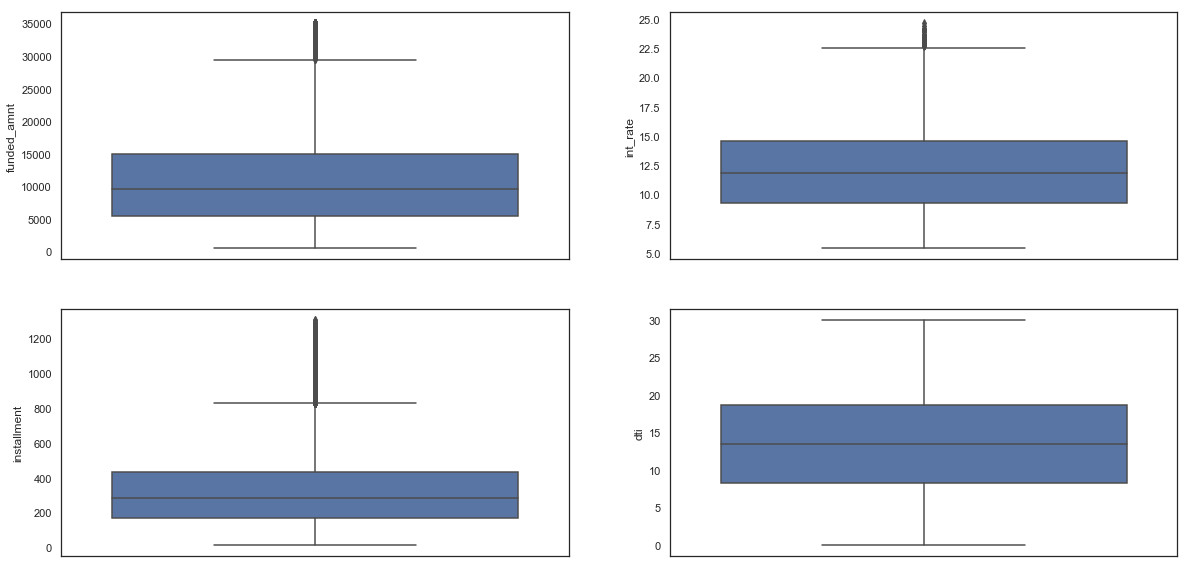

In [118]:
####Univariate Analysis - Box plot on "funded_amnt", "int_rate", "installment", "dti"
p1 = plotInfo("funded_amnt",0,'center')
p2 = plotInfo("int_rate",0,'center')
p3 = plotInfo("installment",0,'center')
p4 = plotInfo("dti",0,'center')
univariateplot("box",[p1,p2,p3,p4],n=4)

##### Observations- Many Loans are applied for 5k, 10k, 15k, 20k, 25k and 35k with median value around 10k USD
##### Interest Rate looks bimodal. Median rate is 11.86%
##### Median of Installment amount is 280 USD per month
##### DTI has a central tendency around 13.4

##### Lets derive few metrics for further analysis

In [119]:
#####Derived Metrics for Issued Month, Year , Income to Loan Ratio and EMI to Salary Ratio
master['issued_month']=pd.to_datetime(master['issue_d'],format='%b-%y').dt.month
master['issued_year']=pd.to_datetime(master['issue_d'],format='%b-%y').dt.year
master['income2loan_ratio']=master['funded_amnt_inv']/master['annual_inc']
master['emi2sal_ratio']=master['installment']/(master['annual_inc']/12)
master.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies,emp_title_clean,issued_month,issued_year,income2loan_ratio,emi2sal_ratio
0,1077501,1296599,5000,5000,4975.0,36.0,10.65,162.87,B,B2,...,Jan-15,171.62,NaN,May-16,0.0,nan,12,2011,0.207292,0.081435
1,1077430,1314167,2500,2500,2500.0,60.0,15.27,59.83,C,C4,...,Apr-13,119.66,NaN,Sep-13,0.0,ryder,12,2011,0.083333,0.023932


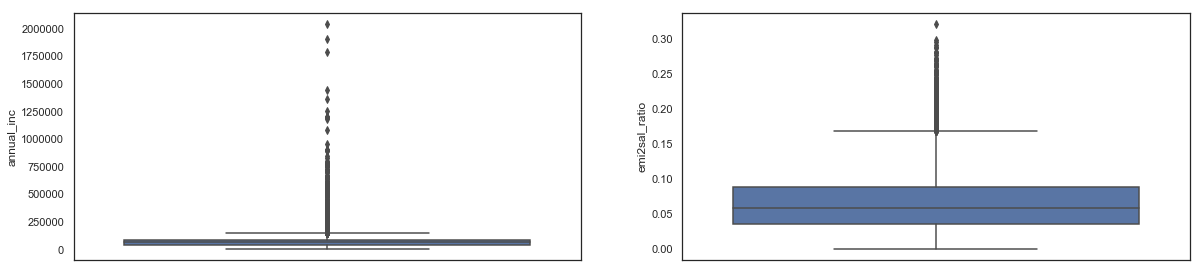

In [120]:
####Univariate Analysis - Box plot on "annual_inc", "emi2sal_ratio"
p1 = plotInfo("annual_inc",0,'center')
p2 = plotInfo("emi2sal_ratio",0,'center')
univariateplot("box",[p1,p2,p3,p4],n=2)

##### There are still few outliers in the Annual Income
##### Most people pay 5% to 10% of their salary as EMI

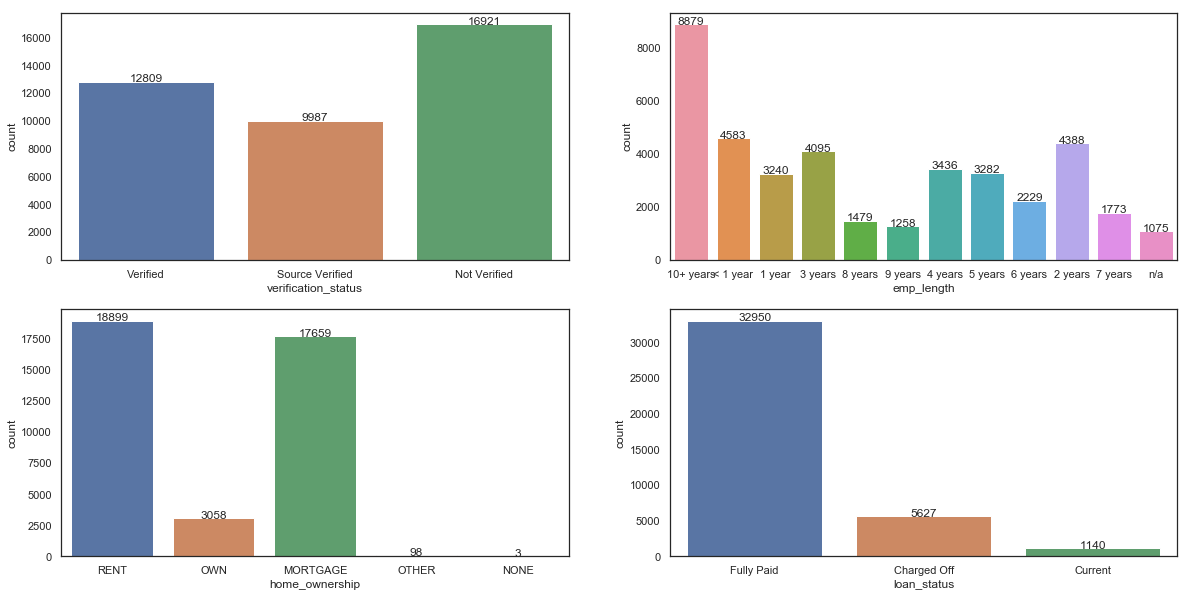

In [121]:
####Univariate Analysis - Count plot on "verification_status", "emp_length", "home_ownership", "loan_status"
p1 = plotInfo("verification_status",0,'center')
p2 = plotInfo("emp_length",0,'center')
p3 = plotInfo("home_ownership",0,'center')
p4 = plotInfo("loan_status",0,'center')
univariateplot("count",[p1,p2,p3,p4],n=4)

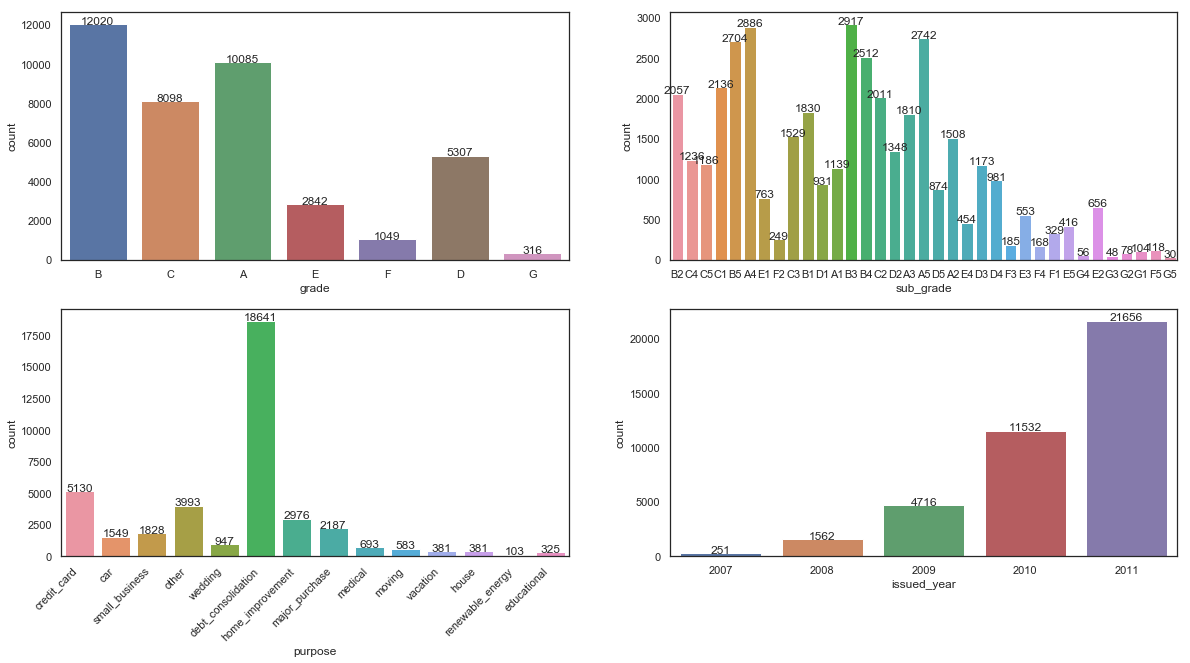

In [122]:
####Univariate Analysis - Count plot on "grade", "sub_grade", "purpose", "issued_year"
p1 = plotInfo("grade",0,'center')
p2 = plotInfo("sub_grade",0,'center')
p3 = plotInfo("purpose",45,'right')
p4 = plotInfo("issued_year",0,'center')
univariateplot("count",[p1,p2,p3,p4],n=4)

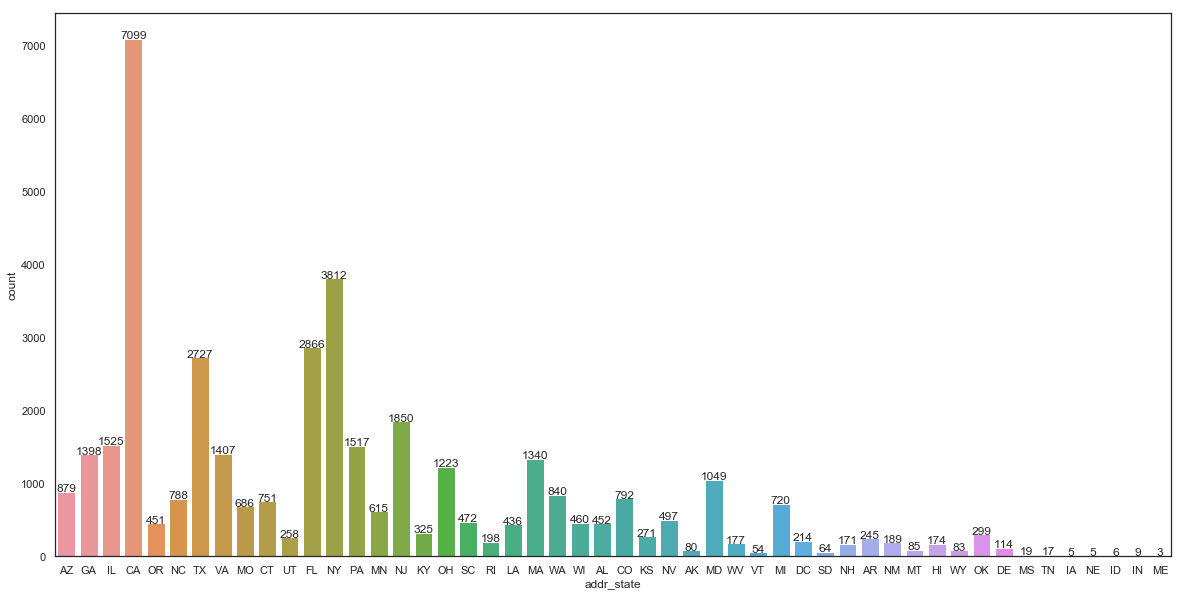

In [123]:
####Univariate Analysis - Count plot on "addr_state"
p1 = plotInfo("addr_state",0,'center')
univariateplot("count",[p1],n=1)

##### Observations- 43% of the loans applications offered with loan are not verified 
##### Most loan applicants who have been offered loans have employment experience of more than 10 yrs
##### California(CA) state has been offered with more loans - 18% 
##### Most loans have been taken for debt consolidation
##### 14% of the loans have been charged off

# Correlation Analaysis

In [124]:
## Find out correlation by key variables
corrmatrix = pd.DataFrame(master[['int_rate','loan_amnt','installment','annual_inc','dti','revol_util']])
corr = corrmatrix.corr()
cmap = cmap=sns.diverging_palette(6, 250, as_cmap=True)
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '180px', 'font-size': '10pt'})\
    .set_precision(2)\

,int_rate,loan_amnt,installment,annual_inc,dti,revol_util
int_rate,1,0.31,0.28,0.064,0.11,0.46
loan_amnt,0.31,1,0.93,0.33,0.066,0.068
installment,0.28,0.93,1,0.33,0.054,0.097
annual_inc,0.064,0.33,0.33,1,-0.14,0.026
dti,0.11,0.066,0.054,-0.14,1,0.28
revol_util,0.46,0.068,0.097,0.026,0.28,1


##### Loan Amount and Installment seems to be have strong correlation.  

# Segmented Univariate Analysis

In [125]:
####Derive four new columns based on interest rate, installment, income to loan ratio and EMI to salary ratio
####And classify the new columns into Low, Moderate and High category based on percentile calculations
####Below 25% -> Low, 25% to 75% -> Moderate , Above 75% -> High
def deriveCat(rate,per25,per75):
    if rate<= per25 : return ("Low")
    elif rate> per25 and rate <per75: return ("Moderate")
    else : return ("High")
    
interest_25per,interest_75per=master['int_rate'].quantile(.25),master['int_rate'].quantile(.75)
master['interest_cat']=master['int_rate'].apply(lambda rate:deriveCat(rate,interest_25per,interest_75per))

install_25per,install_75per=master['installment'].quantile(.25),master['installment'].quantile(.75)
master['installment_cat']=master['installment'].apply(lambda rate:deriveCat(rate,install_25per,install_75per))

income_25per,income_75per=master['income2loan_ratio'].quantile(.25),master['income2loan_ratio'].quantile(.75)
master['inc_to_loan_ratio_cat']=master['income2loan_ratio'].apply(lambda rate:deriveCat(rate,income_25per,income_75per))

emi_25per,emi_75per=master['emi2sal_ratio'].quantile(.25),master['emi2sal_ratio'].quantile(.75)
master['emi_to_inc_ratio_cat']=master['emi2sal_ratio'].apply(lambda rate:deriveCat(rate,emi_25per,emi_75per))

master.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,pub_rec_bankruptcies,emp_title_clean,issued_month,issued_year,income2loan_ratio,emi2sal_ratio,interest_cat,installment_cat,inc_to_loan_ratio_cat,emi_to_inc_ratio_cat
0,1077501,1296599,5000,5000,4975.0,36.0,10.65,162.87,B,B2,...,0.0,nan,12,2011,0.207292,0.081435,Moderate,Low,Moderate,Moderate
1,1077430,1314167,2500,2500,2500.0,60.0,15.27,59.83,C,C4,...,0.0,ryder,12,2011,0.083333,0.023932,High,Low,Low,Low


In [126]:
####Custom Function for Segmented analysis
####Stacked bar plot is used to find the defaulted case across each attribute

def segmentedPlot(dataframe,kind,label,rotation=0,display_value=0):
    dataframe=dataframe.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    ax=dataframe.unstack().sort_values(by='Charged Off',ascending=False).plot(kind=kind,
                                                                    figsize=(25, 10),stacked=True,colormap='Paired')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,fontsize=14, loc='lower center', bbox_to_anchor=(1.05,0.5))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
    ax.grid('on')
    if kind=='bar':
        ax.set_xlabel(label,fontsize = 18)
        ax.set_ylabel('Percentage', fontsize = 18)
        if display_value==1:
            for p in ax.patches: 
                width, height = p.get_width(), p.get_height()
                ax.annotate('{:.0f}%'.format(height), (p.get_x()+.30*width, p.get_y()+.4*height),fontsize=16)
    elif kind=='barh':        
        ax.set_xlabel('Percentage', fontsize = 18)
        ax.set_ylabel(label, fontsize = 18)
        if display_value==1:
            for p in ax.patches:
                width, height = p.get_width(), p.get_height()
                ax.annotate('{:.0f}%'.format(width), (p.get_x()+.1*width, p.get_y()+.4*height),fontsize=16)
    plt.show()
    

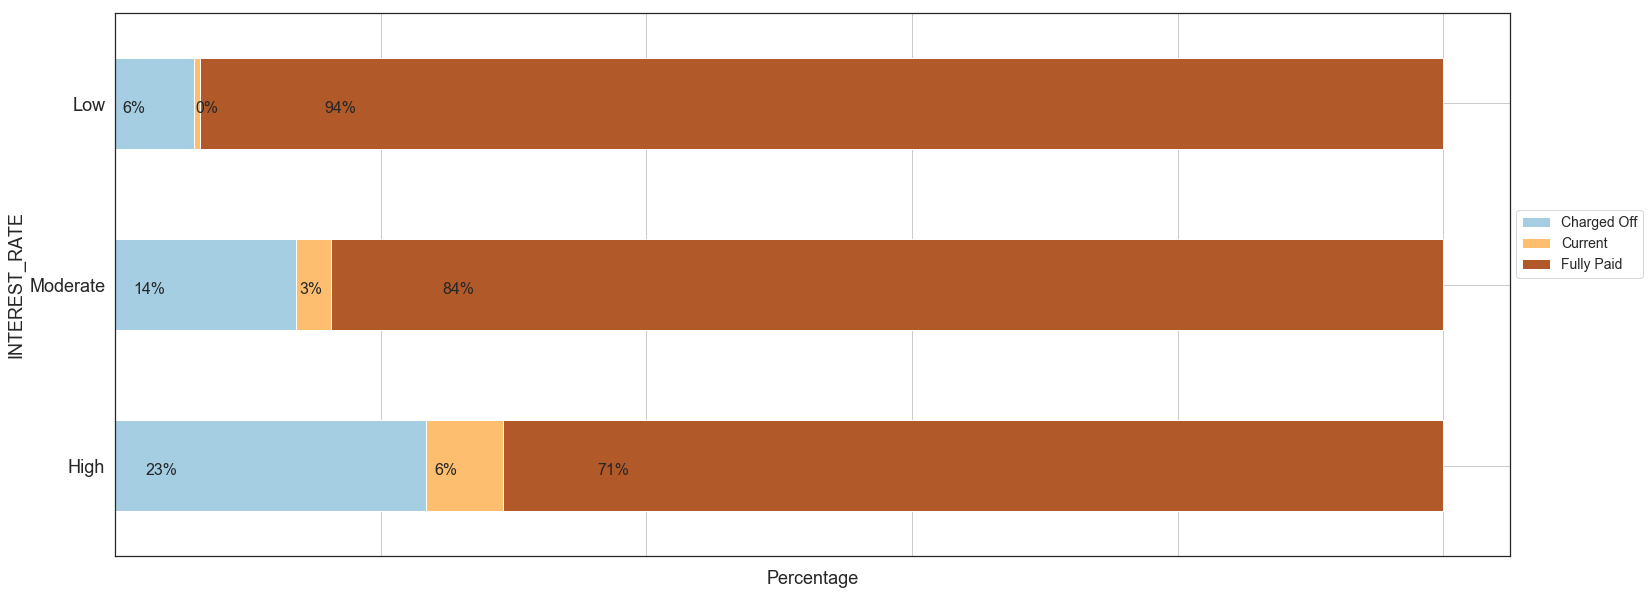

In [127]:
####Segmented plot by Interest Rate by Loan Status
byIntRate = master.groupby(['interest_cat','loan_status'])['loan_status'].count()
segmentedPlot(byIntRate,'barh',"INTEREST_RATE",display_value=1)

##### Observation - Charged off cases are high as the interest rates go higher

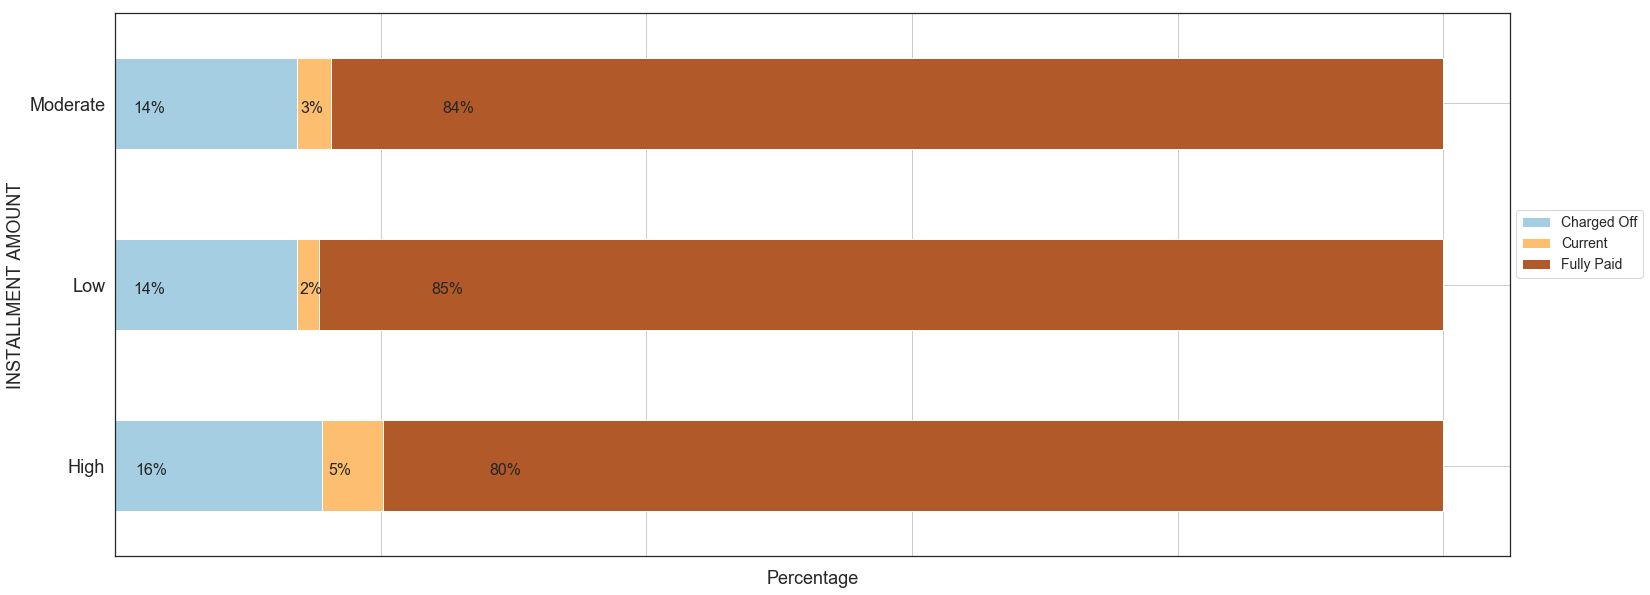

In [128]:
####Segmented plot by Installment amount by Loan Status
byInstallment= master.groupby(['installment_cat','loan_status'])['loan_status'].count()
segmentedPlot(byInstallment,'barh',"INSTALLMENT AMOUNT",display_value=1)

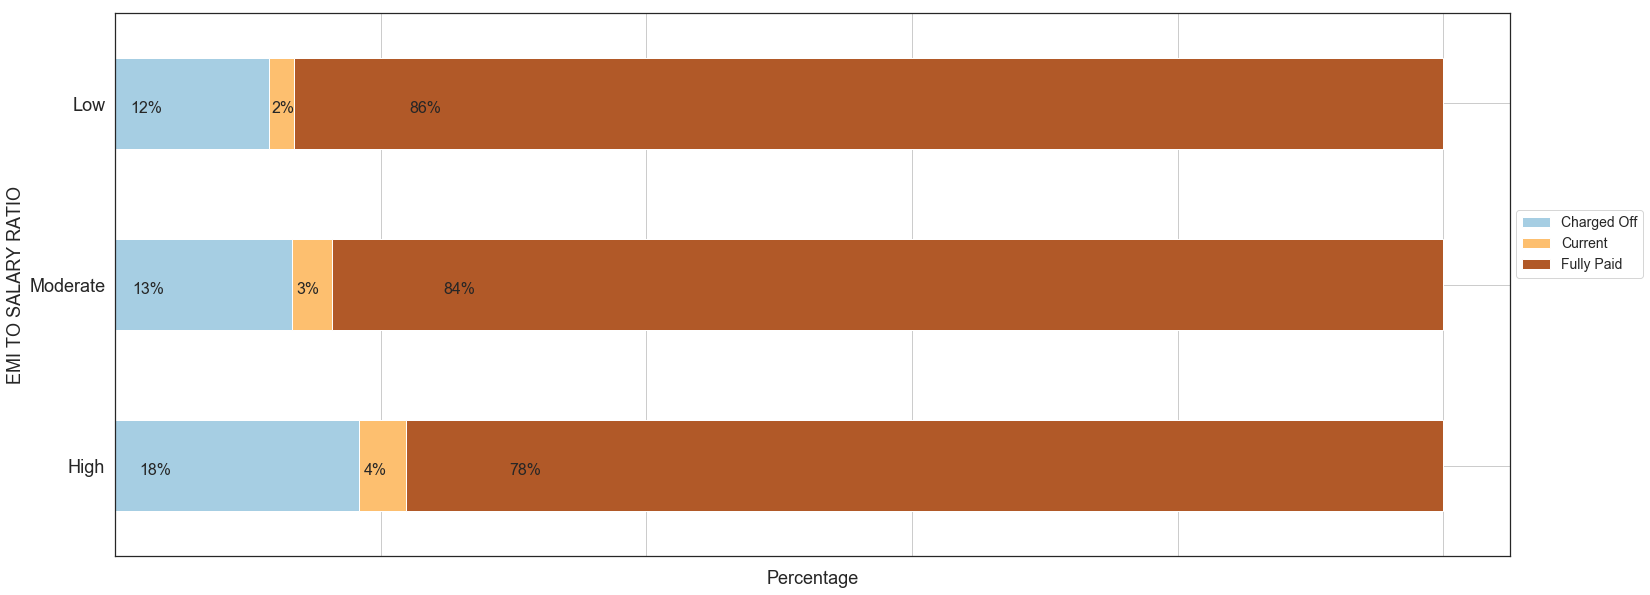

In [129]:
####Segmented plot by Emi to Sal Ration by Loan Status
byEMI = master.groupby(['emi_to_inc_ratio_cat','loan_status'])['loan_status'].count()
segmentedPlot(byEMI,'barh',"EMI TO SALARY RATIO",display_value=1)

##### Observation - Charged off cases increases as EMI amount increases

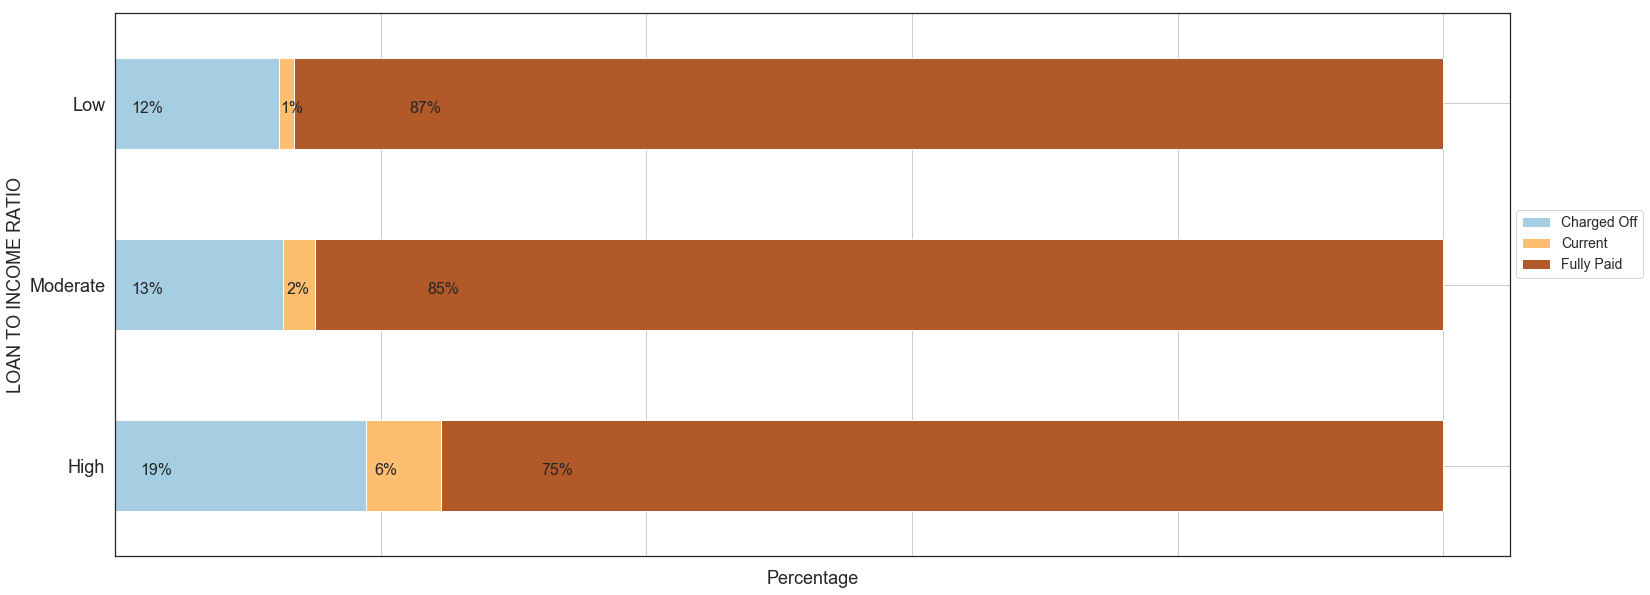

In [130]:
####Segmented plot by Loan to Income Ratio by Loan Status
byIncome = master.groupby(['inc_to_loan_ratio_cat','loan_status'])['loan_status'].count()
segmentedPlot(byIncome,'barh',"LOAN TO INCOME RATIO",display_value=1)

##### Observation - Charged off cases increases as the ratio between loan amount to annual income increases

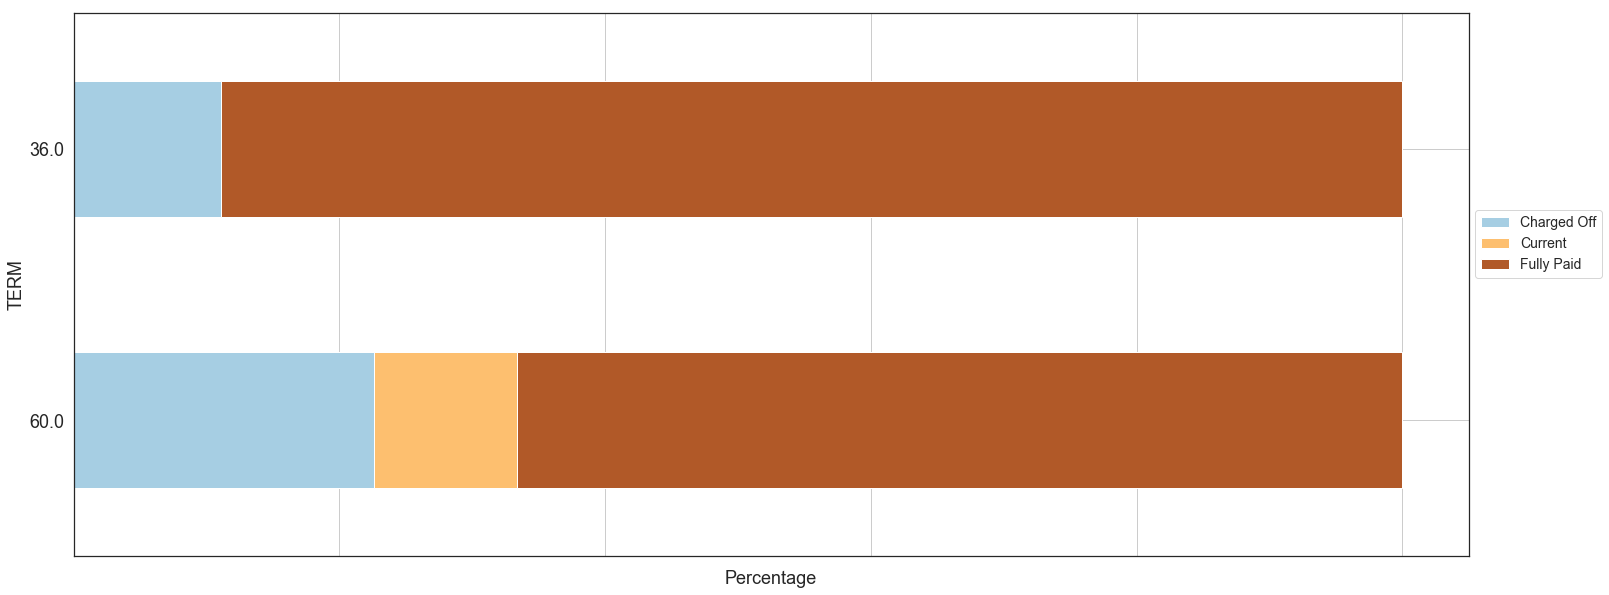

In [131]:
####Segmented plot by Loan to Term by Loan Status
byIncome = master.groupby(['term','loan_status'])['loan_status'].count()
segmentedPlot(byIncome,'barh',"TERM")

##### Observation - Charged off cases increases as the term increases

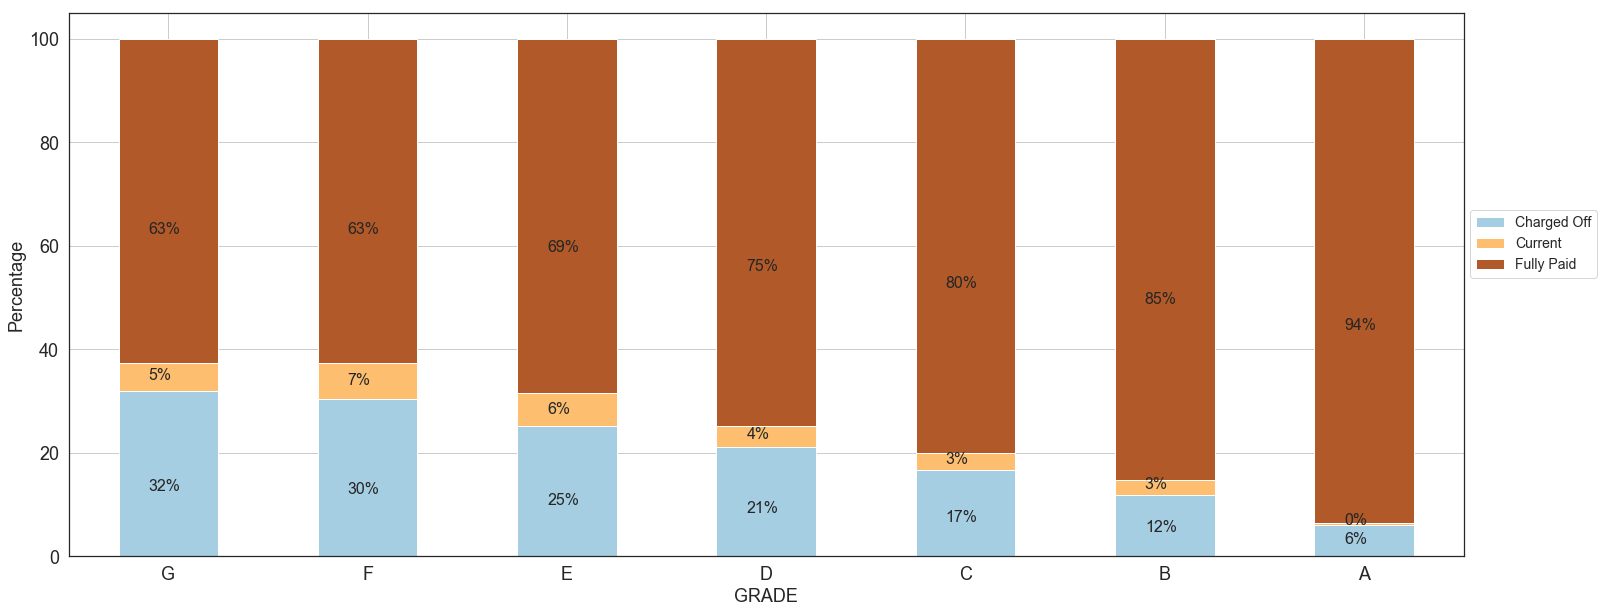

In [132]:
####Segmented plot by Grade by Loan Status
byGrade = master.groupby(['grade','loan_status'])['loan_status'].count()
segmentedPlot(byGrade,'bar',"GRADE",display_value=1)

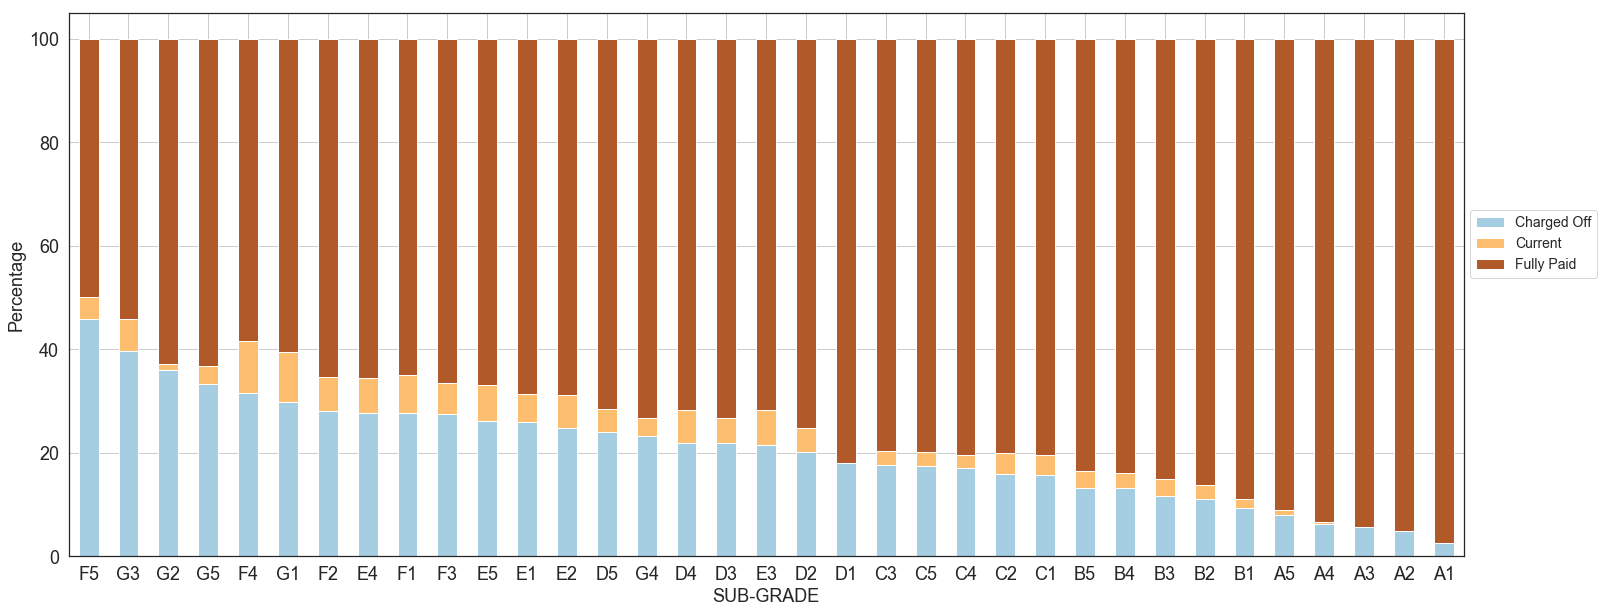

In [133]:
####Segmented plot by SubGrade by Loan Status
bySubGrade = master.groupby(['sub_grade','loan_status'])['loan_status'].count()
segmentedPlot(bySubGrade,'bar',"SUB-GRADE")

##### Observation - There are high charge off cases in 'E' ,'F' & 'G' gardes and 'F5' ,'G3' & 'G2' subgardes

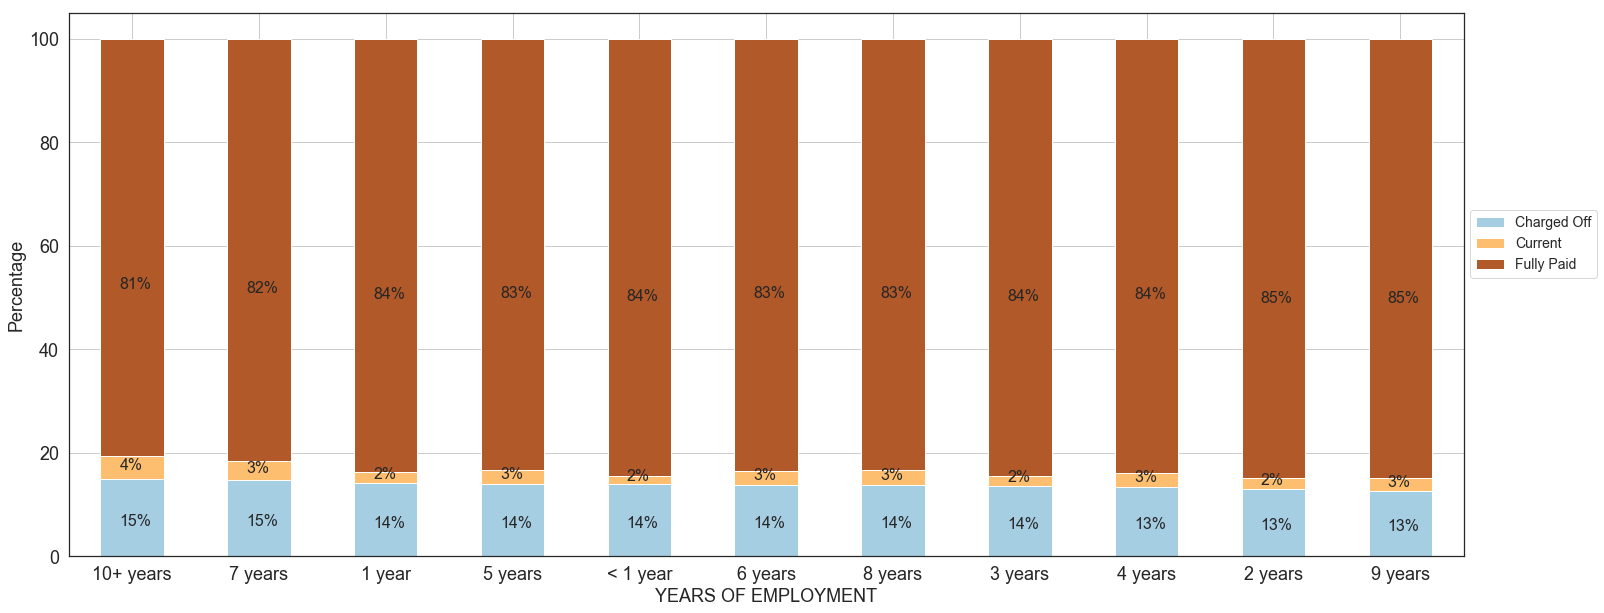

In [134]:
####Segmented plot by Years of Employment by Loan Status
byEmployment = master[~(master.emp_length=='n/a')].groupby(['emp_length','loan_status'])['loan_status'].count()
segmentedPlot(byEmployment,'bar',"YEARS OF EMPLOYMENT",rotation=0,display_value=1)

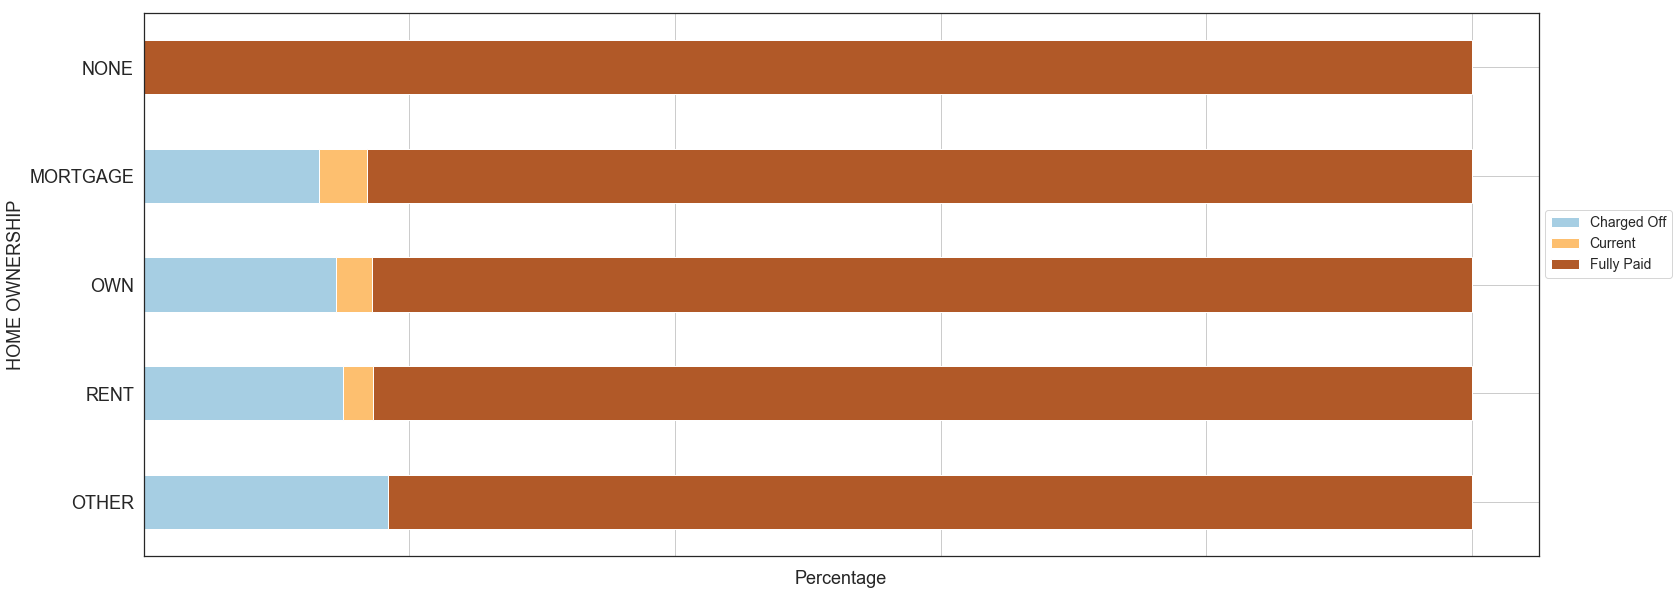

In [135]:
####Segmented plot by Home Ownership by Loan Status
byOwnership = master.groupby(['home_ownership','loan_status'])['loan_status'].count()
segmentedPlot(byOwnership,'barh',"HOME OWNERSHIP",rotation=0)

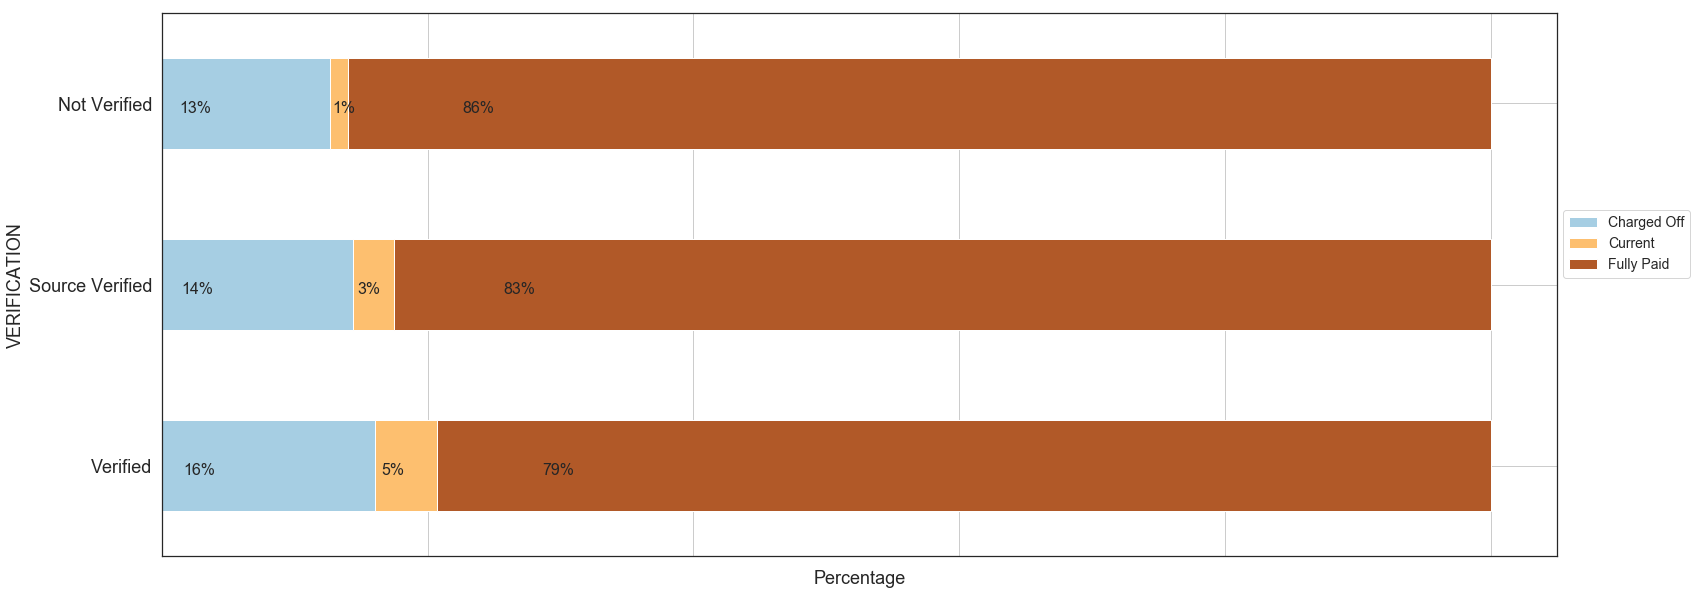

In [136]:
####Segmented plot by Verification status by Loan Status
byVerification = master.groupby(['verification_status','loan_status'])['loan_status'].count()
segmentedPlot(byVerification,'barh',"VERIFICATION",rotation=0,display_value=1)

##### Observation - Even verified loans have lot of default cases

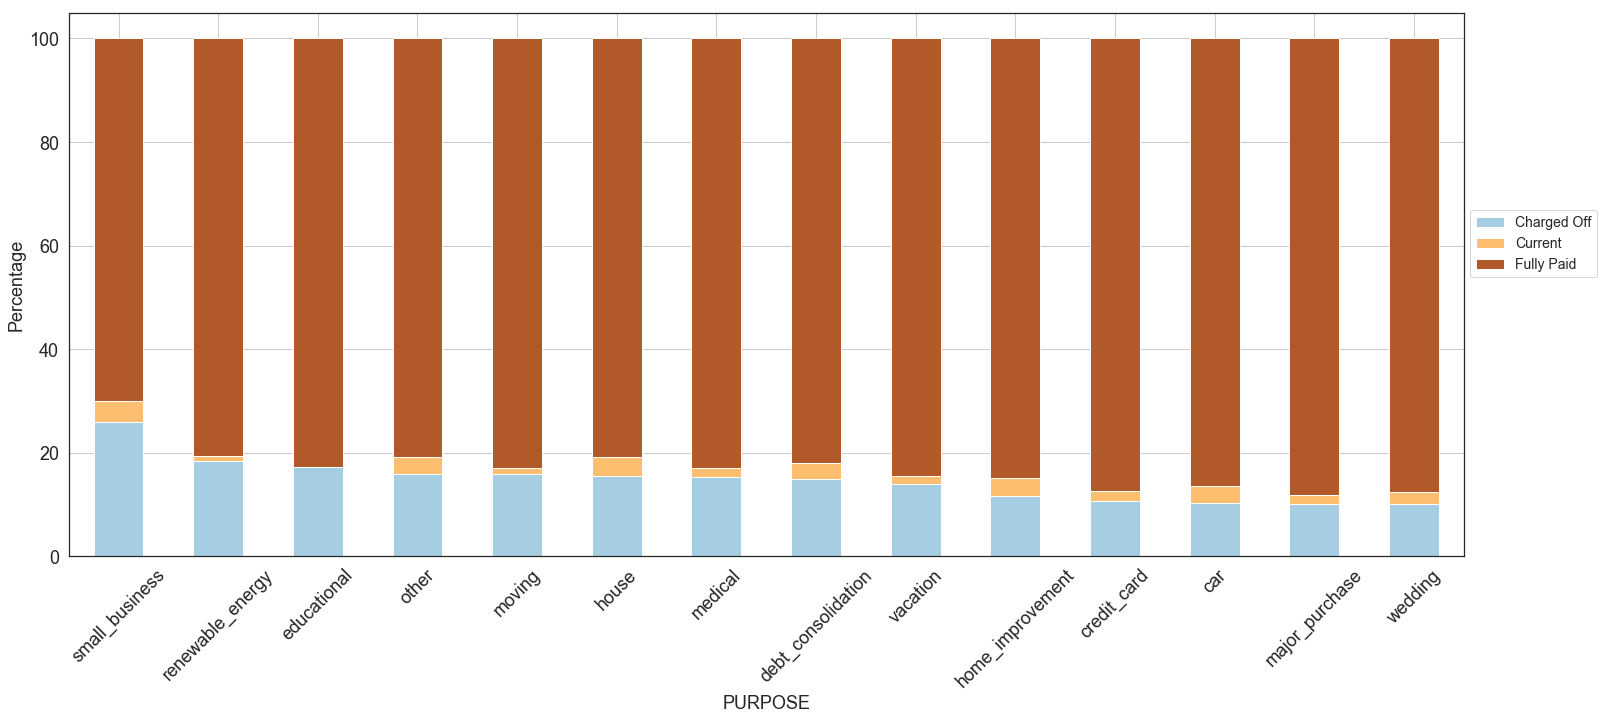

In [137]:
####Segmented plot by Purpose by Loan Status
byPurpose = master.groupby(['purpose','loan_status'])['loan_status'].count()
segmentedPlot(byPurpose,'bar',"PURPOSE",rotation=45)

##### Observation - Loans taken for small business tend to default more

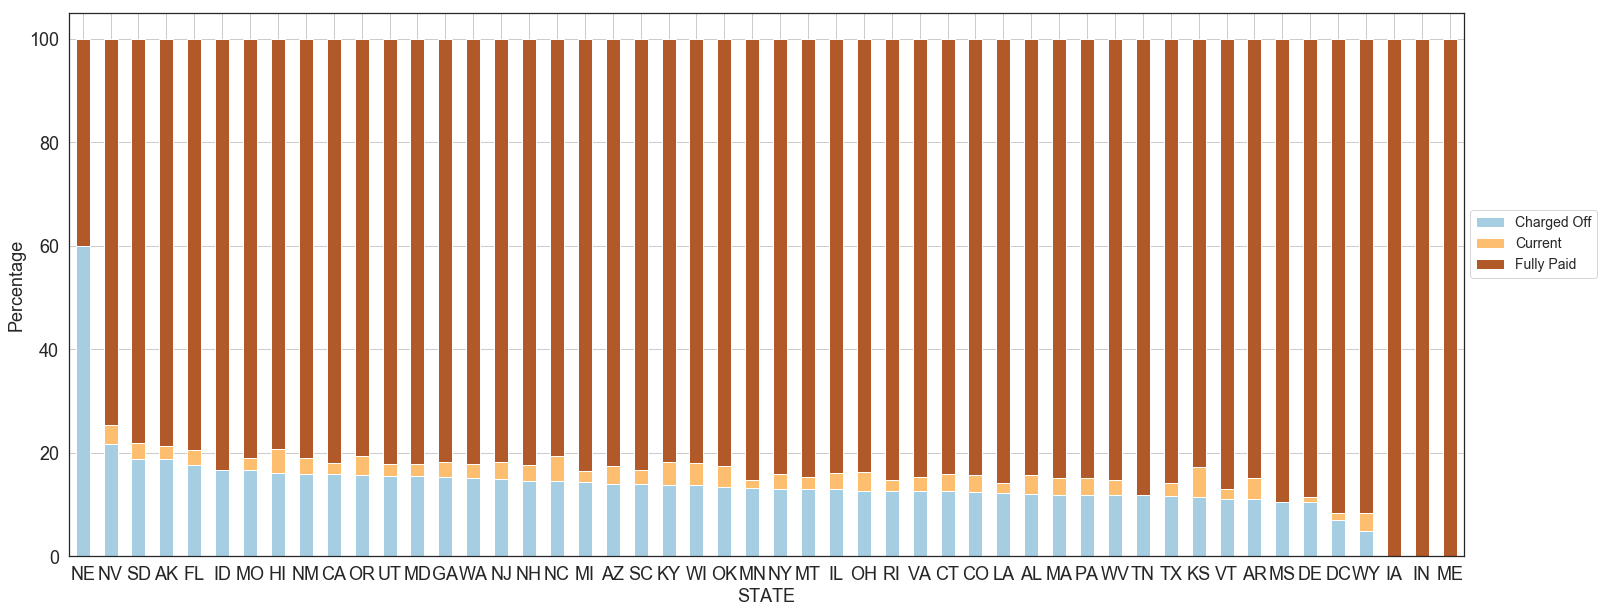

In [138]:
####Segmented plot by State by Loan Status
byState = master.groupby(['addr_state','loan_status'])['loan_status'].count()
segmentedPlot(byState,'bar',"STATE")

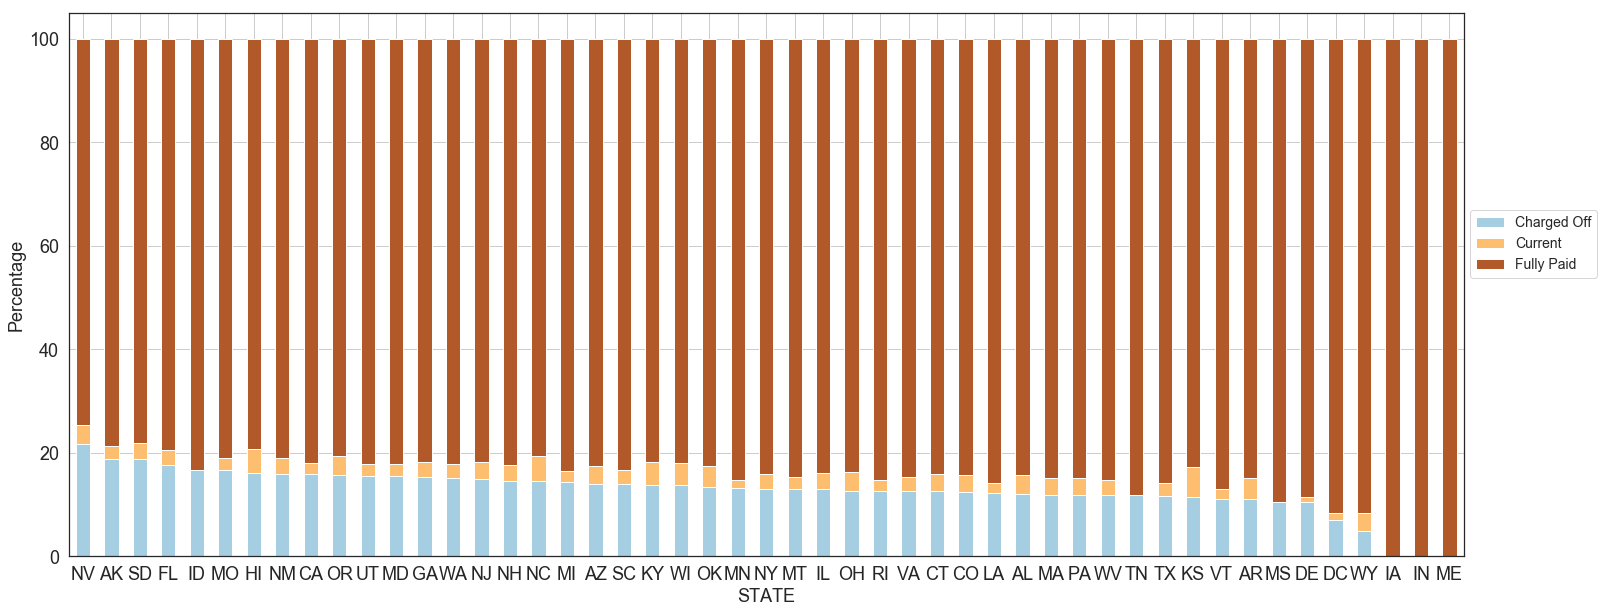

In [139]:
####Segmented plot by State by Loan Status with Nebraska state removed
byState = master[~(master.addr_state=='NE')].groupby(['addr_state','loan_status'])['loan_status'].count()
segmentedPlot(byState,'bar',"STATE")

##### Observation - Nebraska(NE) state has more charged off cases but on further analysis it looks like an outlier as only few had availed loan. So most charged off loan are in the state Nevada(NV)

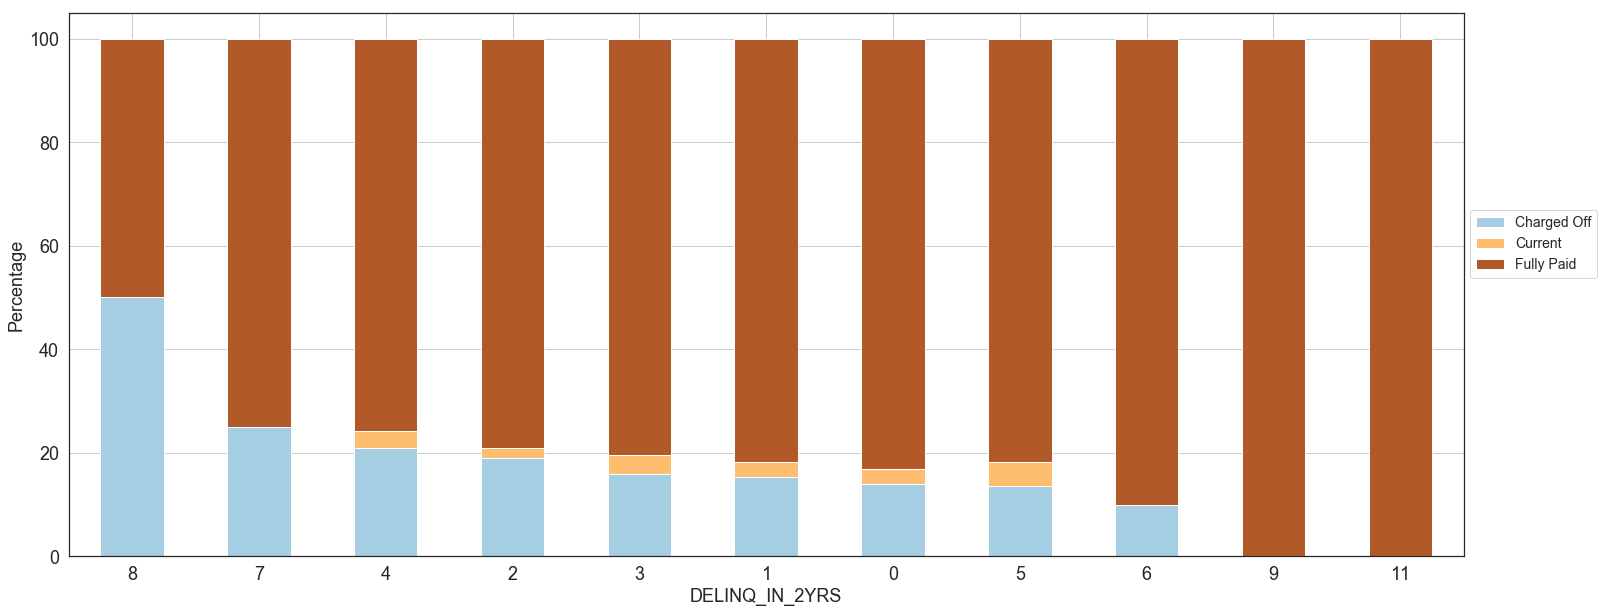

In [140]:
####Segmented plot by delinq 2 years by Loan Status
byDelinq = master.groupby(['delinq_2yrs','loan_status'])['loan_status'].count()
segmentedPlot(byDelinq,'bar',"DELINQ_IN_2YRS")

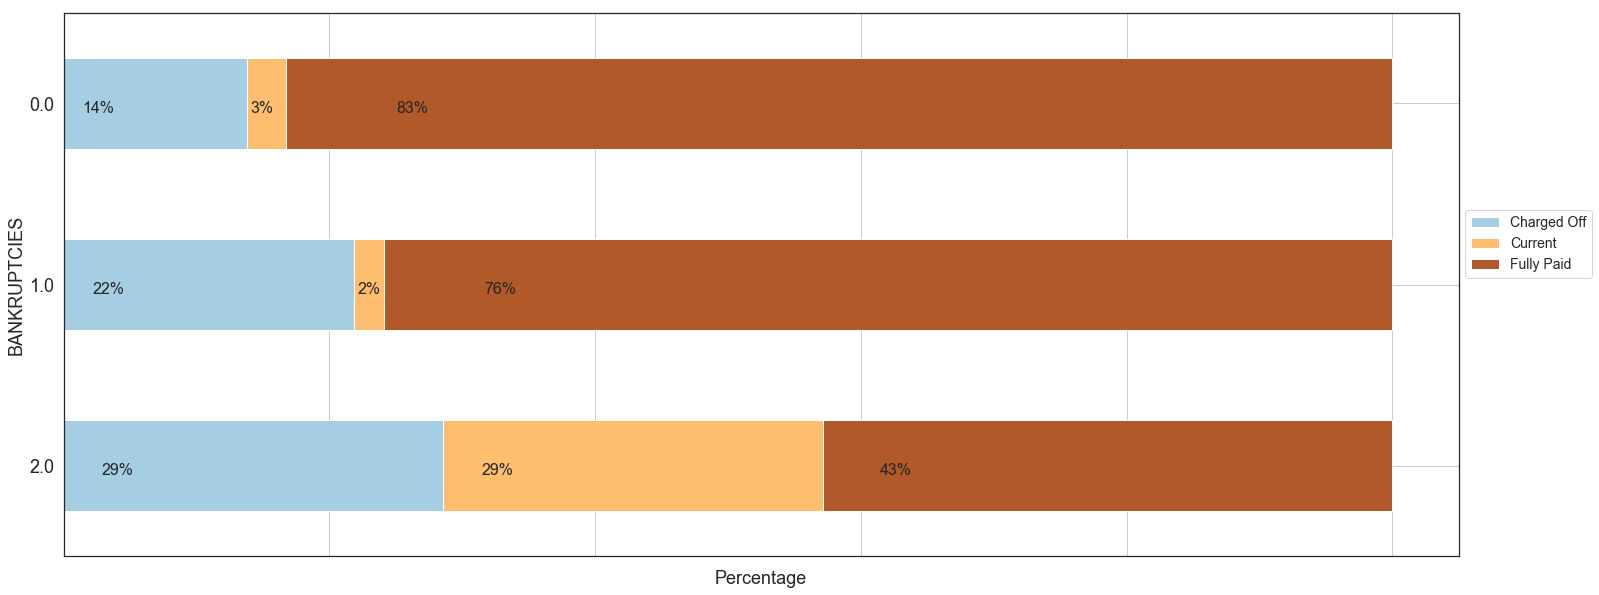

In [141]:
####Segmented plot by pub_rec_bankruptcies  by Loan Status
byBankrupt = master.groupby(['pub_rec_bankruptcies','loan_status'])['loan_status'].count()
segmentedPlot(byBankrupt,'barh',"BANKRUPTCIES",display_value=1)

##### Observation - More the bankruptcies filed more are the loan defaults

##### Lets do some univariate analysis only on the charged off cases

## Segmented Univariate Analysis - only charged off cases

In [142]:
charged_off=master[master.loan_status=='Charged Off']

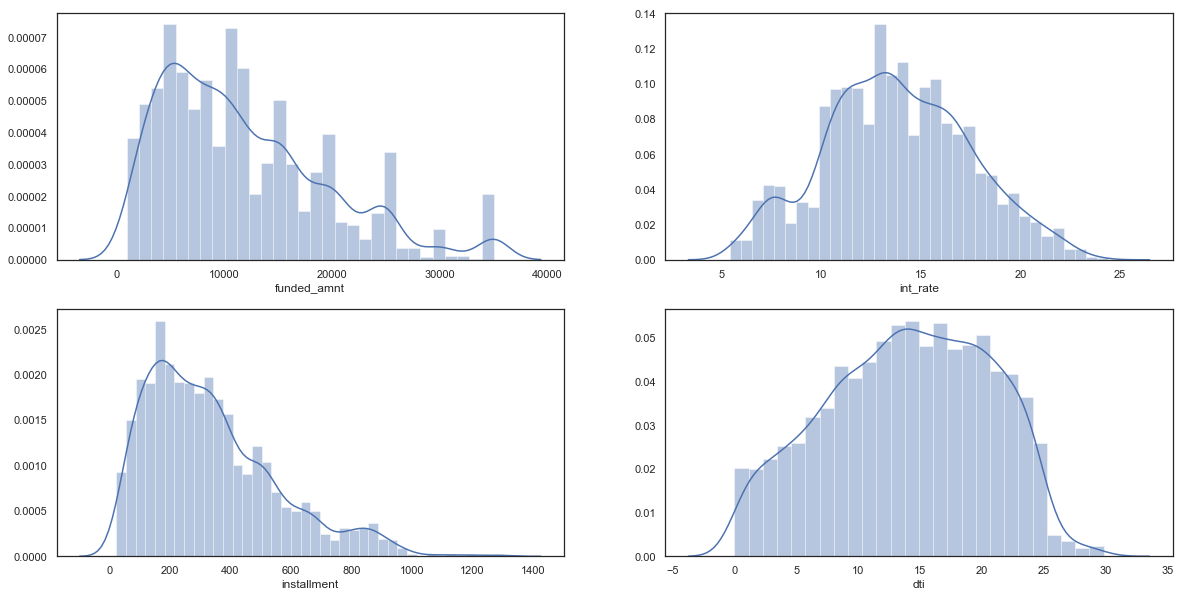

In [143]:
####Segmented Univariate Analysis - Histogram on "funded_amnt", "int_rate", "installment", "dti"
p1 = plotInfo("funded_amnt",0,'center')
p2 = plotInfo("int_rate",0,'center')
p3 = plotInfo("installment",0,'center')
p4 = plotInfo("dti",0,'center')
univariateplot("dist",[p1,p2,p3,p4],n=4,df=charged_off)

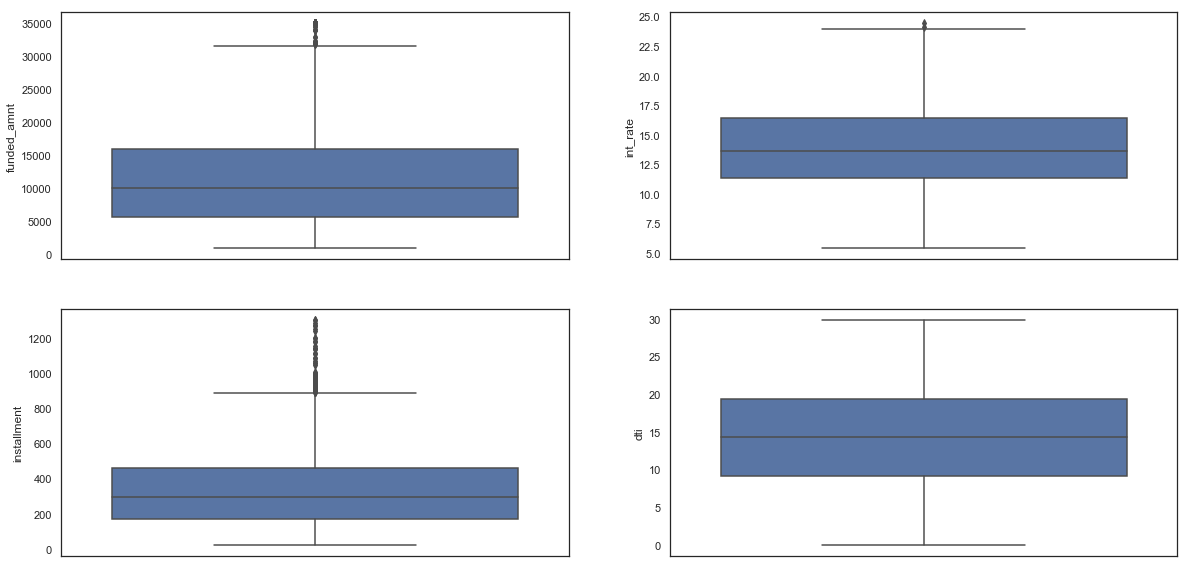

In [144]:
####Segmented Univariate Analysis - Box plot on "funded_amnt", "int_rate", "installment", "dti"
p1 = plotInfo("funded_amnt",0,'center')
p2 = plotInfo("int_rate",0,'center')
p3 = plotInfo("installment",0,'center')
p4 = plotInfo("dti",0,'center')
univariateplot("box",[p1,p2,p3,p4],n=4,df=charged_off)

##### Observations - Interest Rates for the charged off cases are bit higher with median around 14%
##### DTI is also slightly higher for the charged off cases

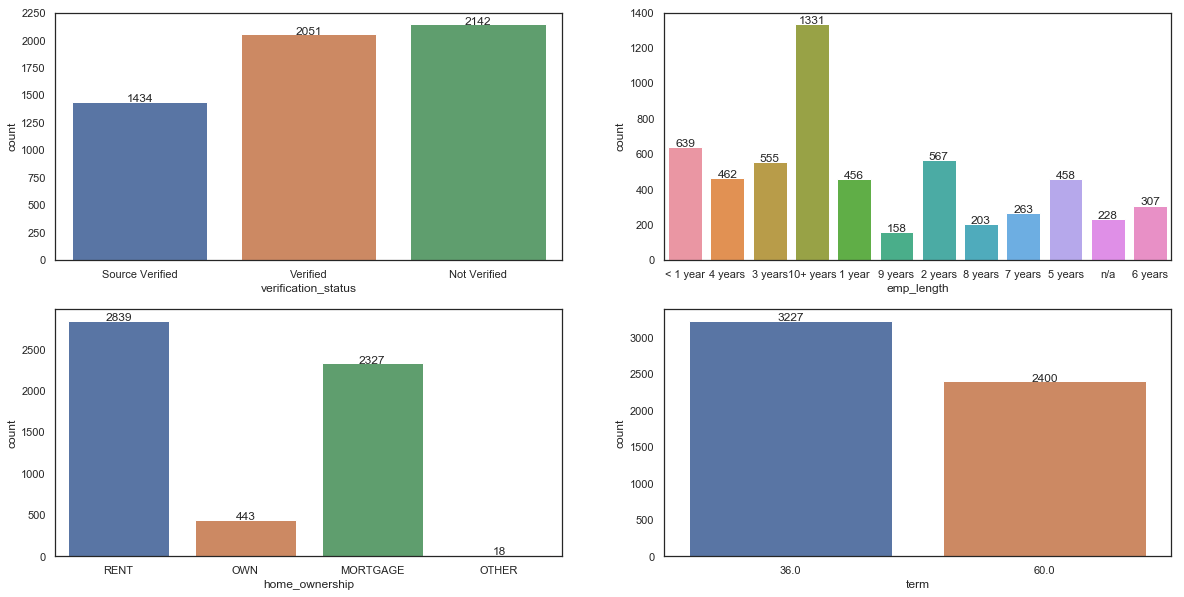

In [145]:
####Segmented Univariate Analysis - Count plot on "verification_status", "emp_length", "home_ownership", "loan_status"
p1 = plotInfo("verification_status",0,'center')
p2 = plotInfo("emp_length",0,'center')
p3 = plotInfo("home_ownership",0,'center')
p4 = plotInfo("term",0,'center')
univariateplot("count",[p1,p2,p3,p4],n=4,df=charged_off)

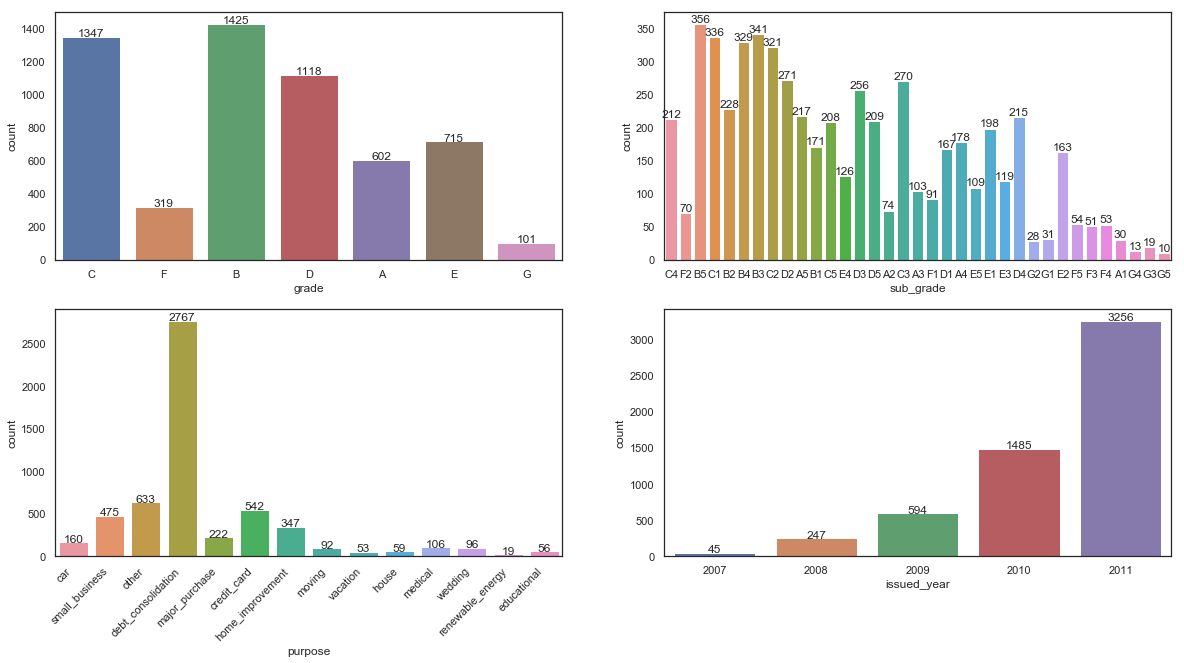

In [146]:
####Segmented Univariate Analysis - Count plot on "grade", "sub_grade", "purpose", "issued_year"
p1 = plotInfo("grade",0,'center')
p2 = plotInfo("sub_grade",0,'center')
p3 = plotInfo("purpose",45,'right')
p4 = plotInfo("issued_year",0,'center')
univariateplot("count",[p1,p2,p3,p4],n=4,df=charged_off)

##### Observations - Most of the charged off cases are not verified 
##### Most loan applicants who have been defaulted have employment experience of more than 10 yrs
##### Most charged off loan belong to debt consolidation

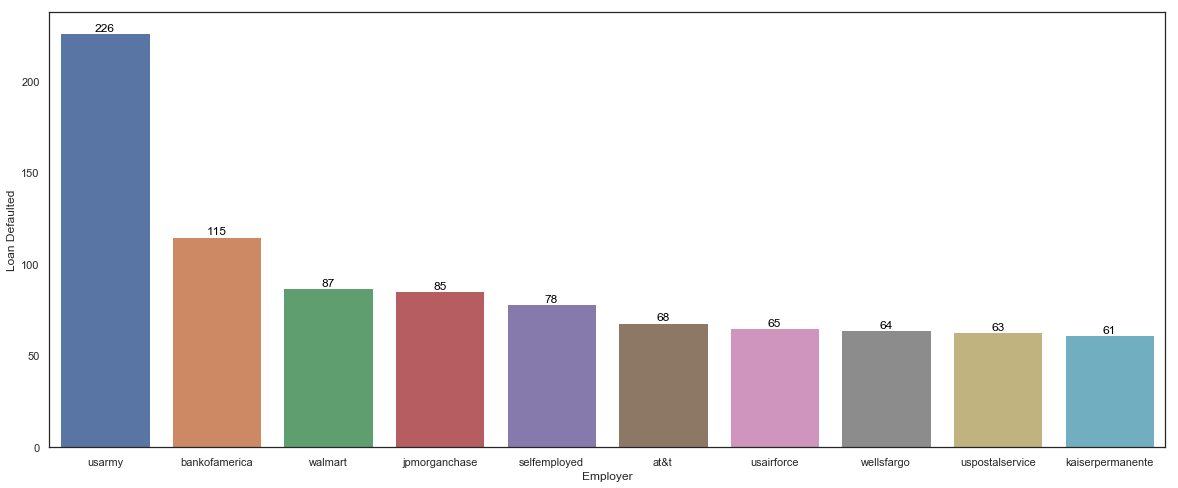

In [147]:
####plots to show defaulted by employers 
plt.figure(figsize=(20, 8))
top10=master[(~(master.loan_status=='Charged Off')) & (~(master.emp_title_clean=='nan'))].groupby(['emp_title_clean'])['loan_status'].agg([("count",'count')]).sort_values(by='count',ascending=False).head(10)
top10=top10.reset_index()
ax= sns.barplot(x='emp_title_clean', y='count', data=top10)
ax.set(xlabel='Employer', ylabel='Loan Defaulted')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.show()

##### Observation - Employees of US Army have defaulted the most

# Bivariate Analysis

In [148]:
#### Define a custom function to plot multiple variables
def bivariate(x,y):
    plt.figure(figsize=(20, 8))
    sns.boxplot(x,y,hue='loan_status',data=master)
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
    plt.show()

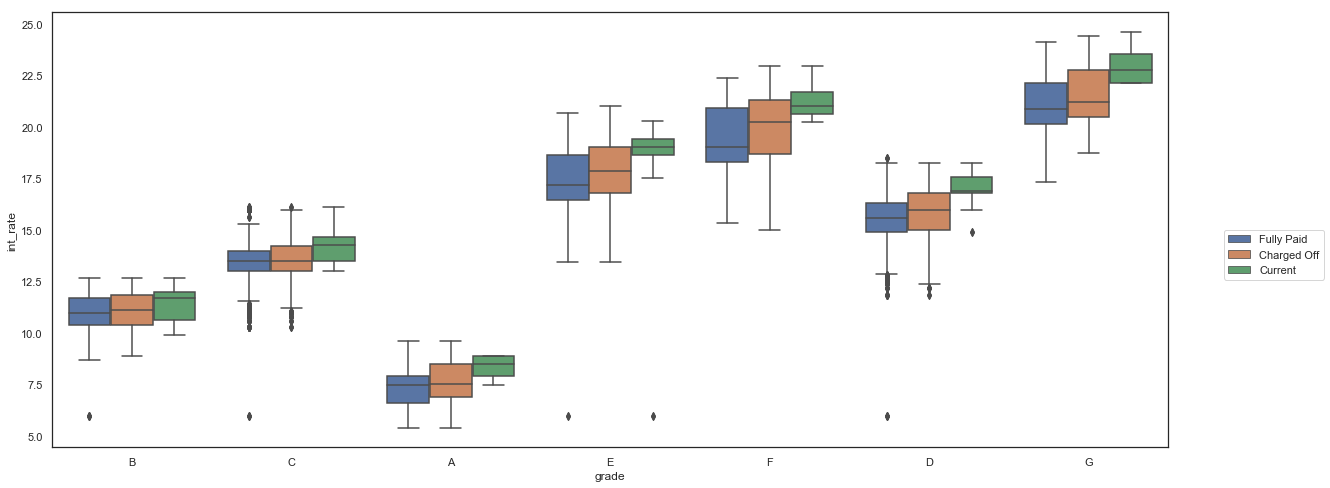

In [149]:
####bivariate plot by grade and interest rate 
bivariate('grade','int_rate')

##### Observation - There is high correlation between grades and interest rates. Higher the interest rate=> Higher the grade (A to G)

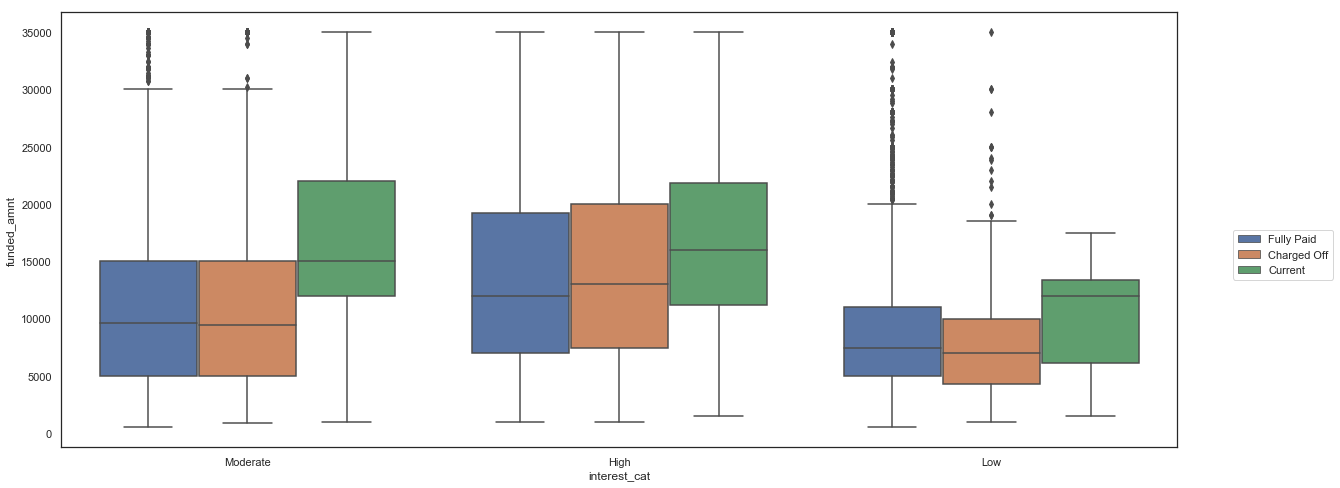

In [150]:
####bivariate plot by interest rate and funded amount
bivariate('interest_cat','funded_amnt')

##### Observation - Higher the funded amount => Higher the interest rate

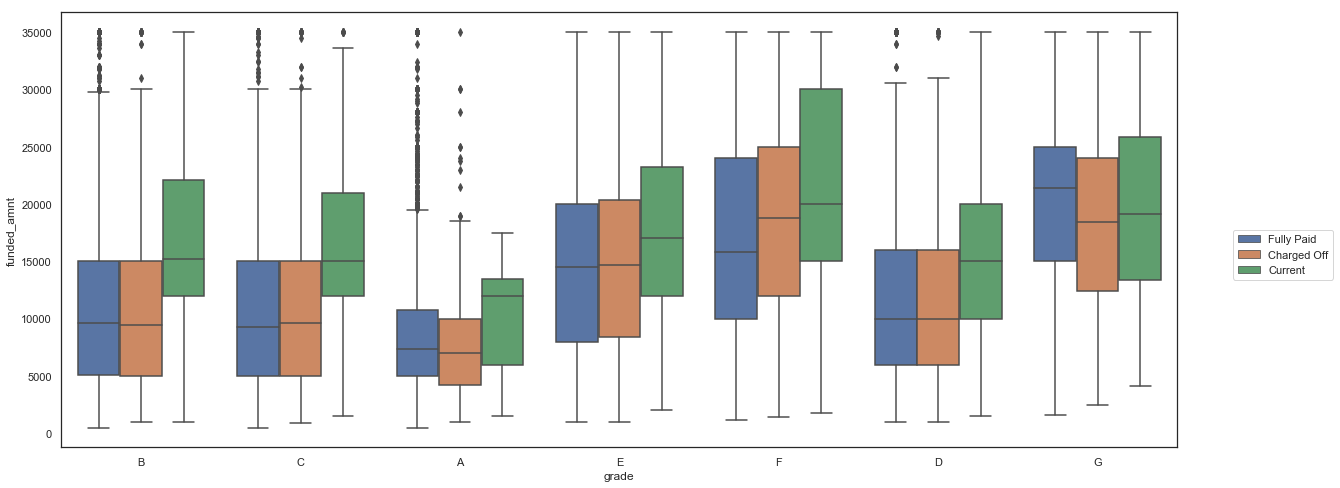

In [151]:
####bivariate plot by grade and funded amount
bivariate('grade','funded_amnt')

##### Observation -  Higher the funded amount => Higher the Grade(from A to G)

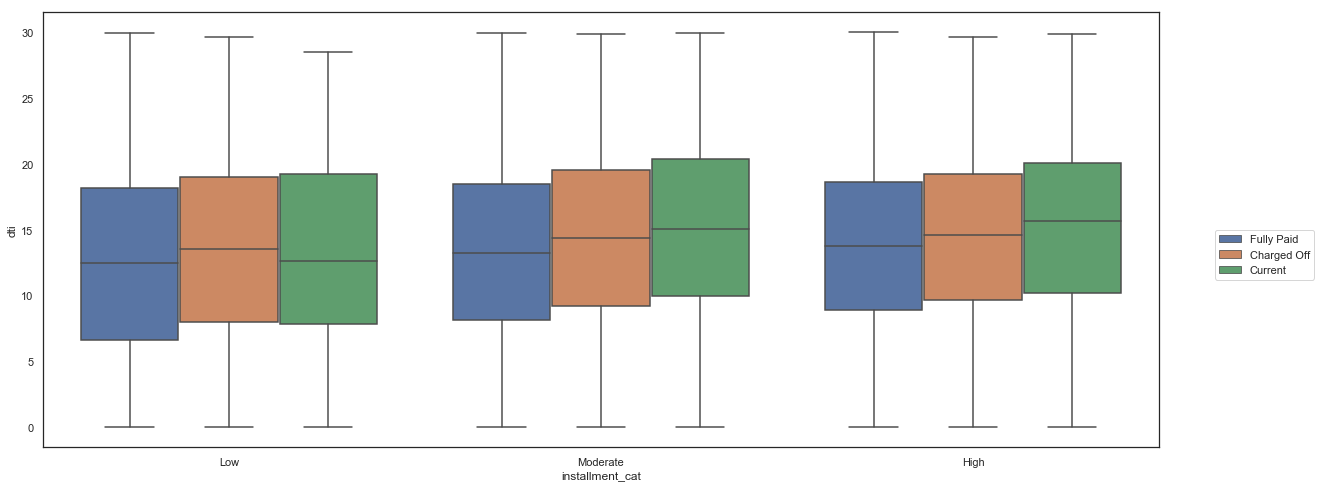

In [152]:
####bivariate plot by grade and dti
bivariate('installment_cat','dti')

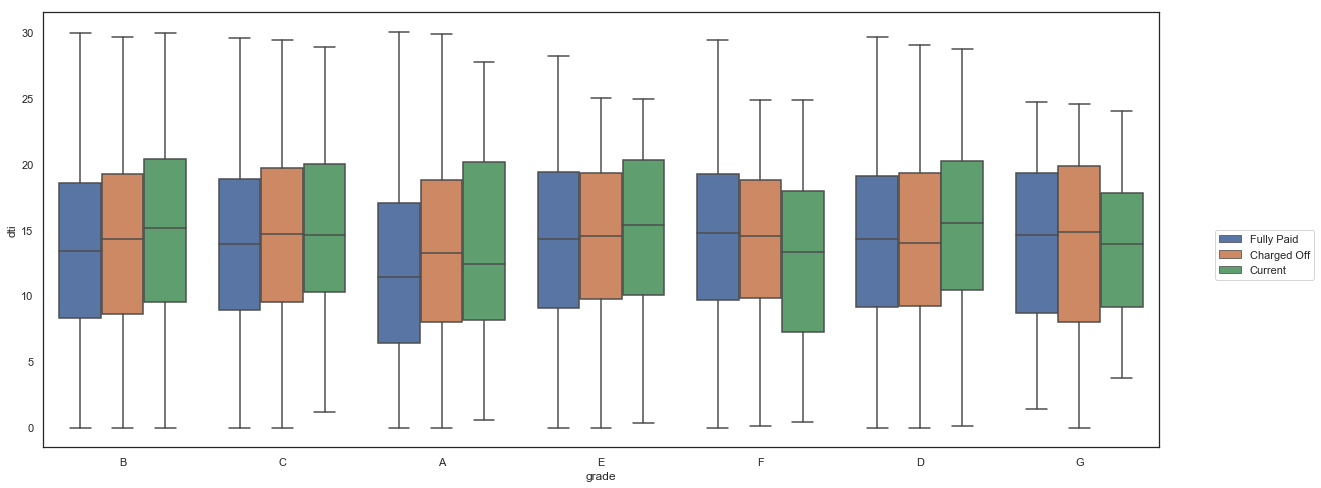

In [153]:
####bivariate plot by grade and dti
bivariate('grade','dti')

##### Observation - DTI is similar across grades

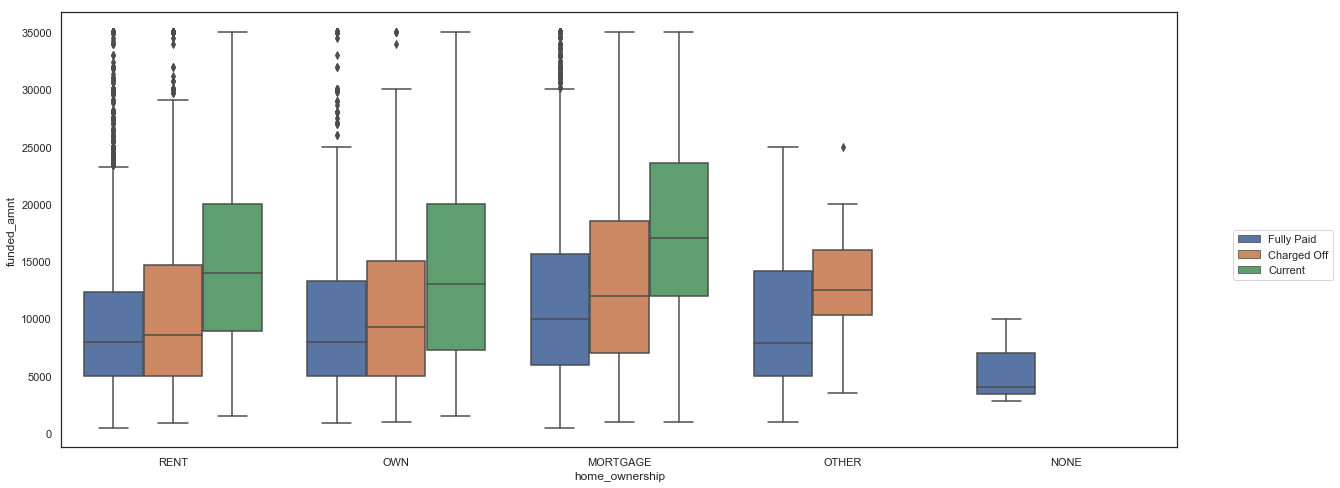

In [154]:
####bivariate plot by homeownership and funded amount
bivariate('home_ownership','funded_amnt')

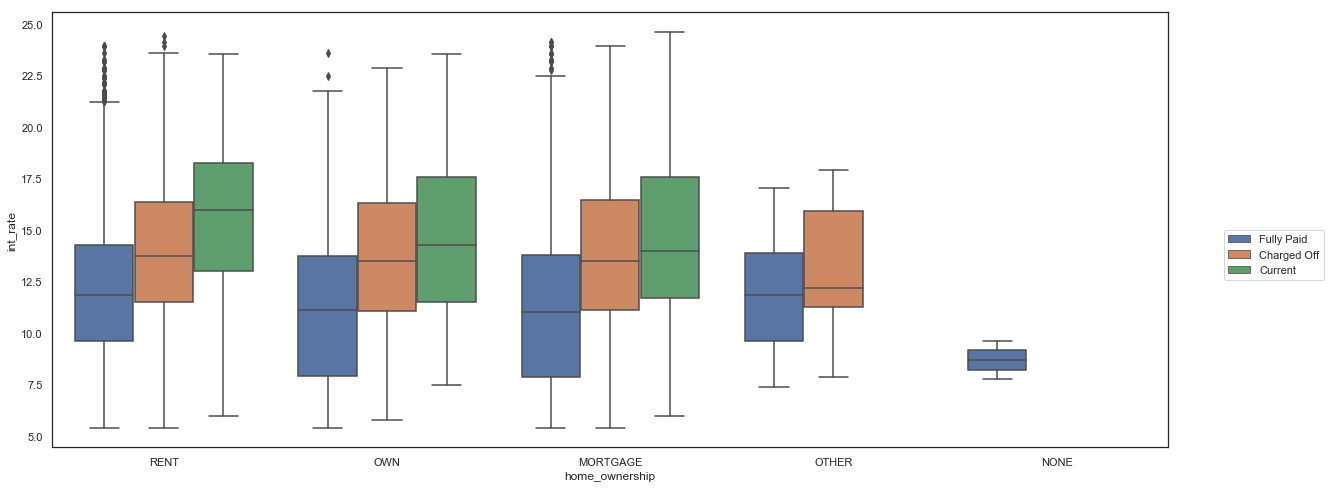

In [155]:
####bivariate plot by homeownership and interest rate
bivariate('home_ownership','int_rate')

##### Observation - Home ownership doesnt have much influence on the funded amount and interest rates

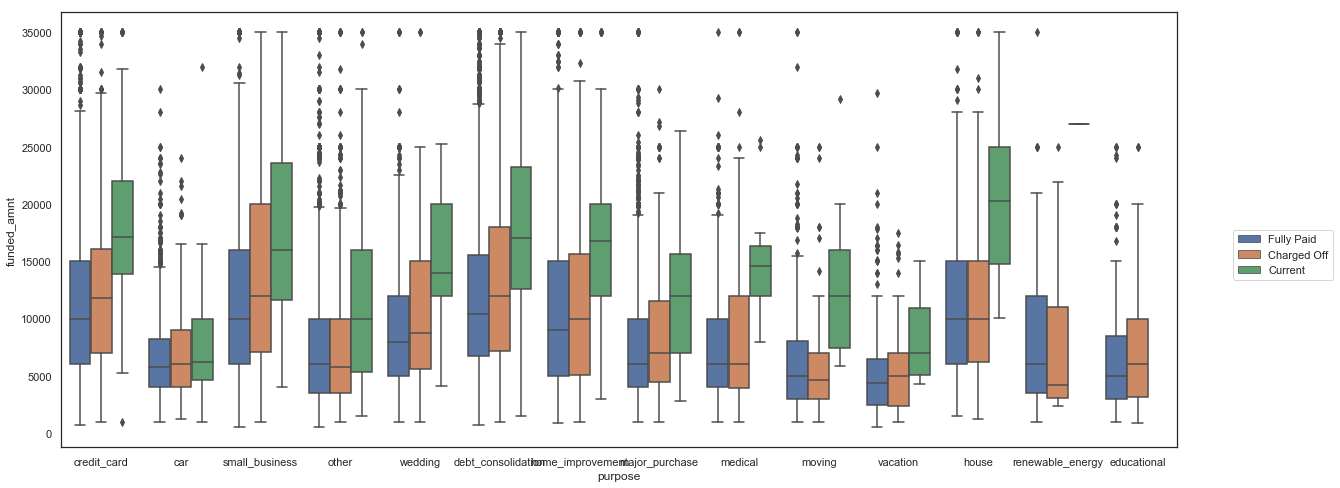

In [156]:
####bivariate plot by purpose and funded amount
bivariate('purpose','funded_amnt')

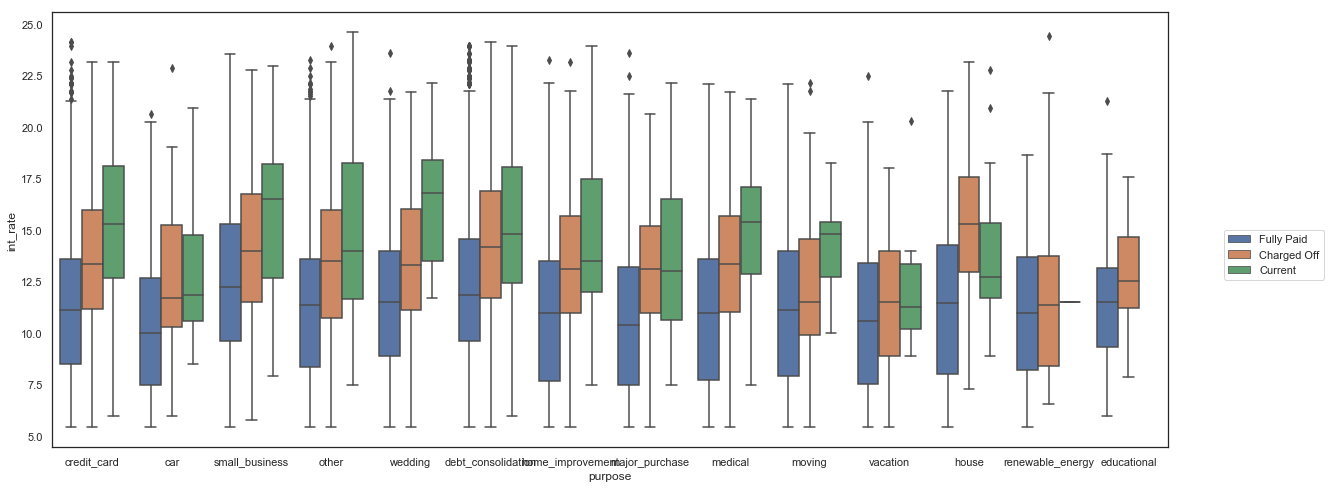

In [157]:
####bivariate plot by purpose and interest rate
bivariate('purpose','int_rate')

##### Observation - Loan amount offered is higher for Credit cards, Small Business , Debt Consolidation and Housing
##### Most of the current loan is in higher bracket of loan amount . So there is chance that many will be defaulted

# MultiVariate Analysis

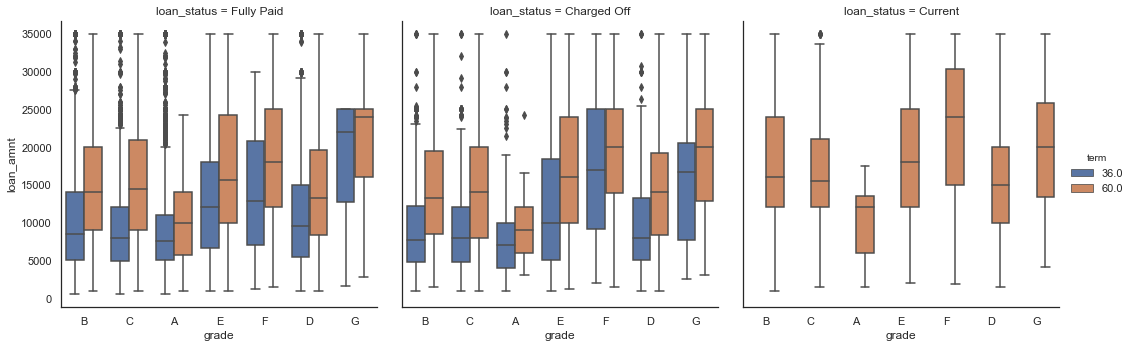

In [158]:
####multivariable plot by grade,loan amount, loan status and term
## to cat plot work you need seaborn version 0.9.0
## windows - @conda prompt use this command pip install seaborn==0.9.0
g = sns.catplot(x="grade", y="loan_amnt",col="loan_status",hue="term", data=master,kind="box") 
plt.show()

##### Observation - It’s evident that Grades E,F and G seems to have consistent showing high.

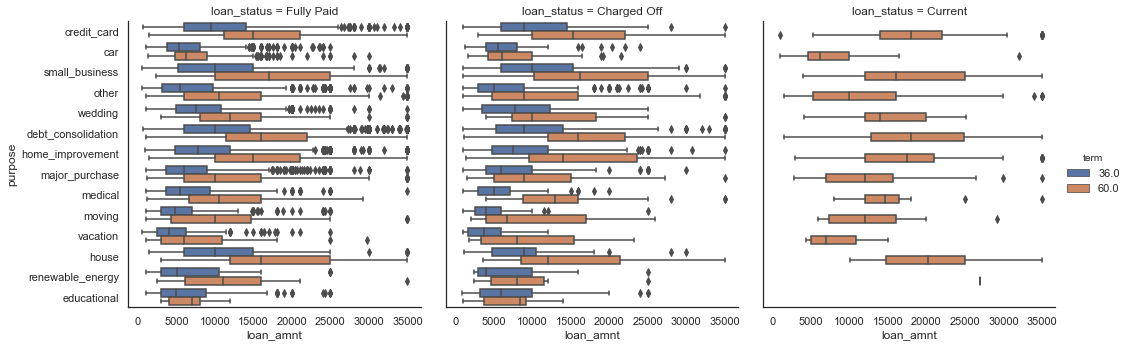

In [159]:
####multivariable plot by purpose,loan amount, loan status and term
## to cat plot work you need seaborn version 0.9.0
## windows - @conda prompt use this command pip install seaborn==0.9.0
g = sns.catplot(x="loan_amnt", y="purpose",col="loan_status",hue="term",
                 data=master,kind="box")
plt.show()

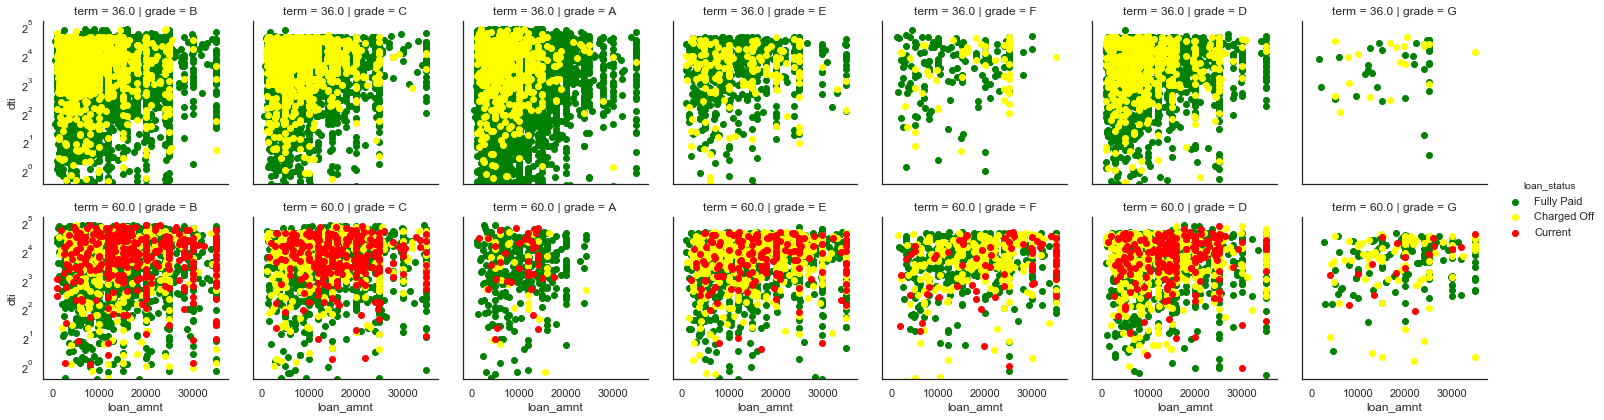

In [160]:
plt.figure(figsize=(20, 10))
pal = ["green","yellow","red"]
g = sns.FacetGrid(master, col="grade",row='term',hue="loan_status",palette=pal)
g = (g.map(plt.scatter, "loan_amnt","dti").add_legend())
plt.yscale('log',basey=2)
plt.show()

##### Observation - Its evident that with increased DTI,  charged off cases are also more
##### Moreover for low levels of DTI, 60 months term have more default cases when compared with 36 months term particularly in grade F and G

# Time Series Analysis

In [161]:
## create pivot table loan issued month and loan issued year.
year_month=pd.pivot_table(master,values='funded_amnt',index='issued_year',columns='issued_month',aggfunc='mean')
year_month

issued_month,1,2,3,4,5,6,7,8,9,10,11,12
issued_year,,,,,,,,,,,,
2007,NaN,NaN,NaN,NaN,NaN,7500.000000,5723.333333,6317.424242,8112.500000,5834.574468,10287.162162,11336.764706
2008,10188.888889,9651.580460,11414.936441,6860.161290,5334.859155,5720.454545,5853.313253,4510.563380,4722.656250,8004.687500,8952.309783,9636.547085
2009,9145.606695,8981.153846,9613.224638,9210.517241,9478.605016,8966.221910,9321.991979,9635.110294,10191.926503,10297.064220,10244.559801,10854.055184
2010,11171.010187,10816.108453,10364.077341,10468.047158,10210.000000,9146.428571,9641.108132,10306.980519,10173.987109,10345.450530,9540.789474,10117.719021
2011,10737.518116,11245.393215,11410.810811,11203.585147,10829.070456,10887.383689,10962.513369,11887.668568,12058.095007,12957.686850,12642.858749,13671.703540


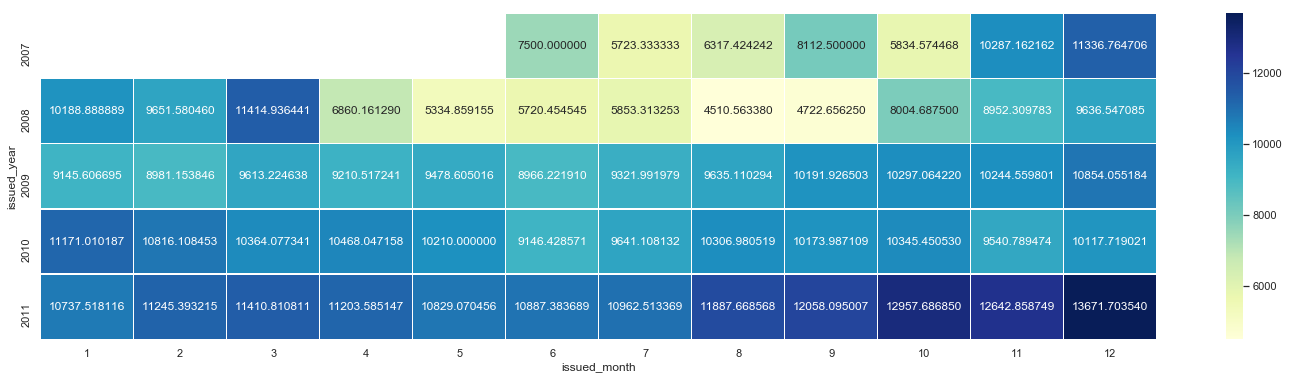

In [162]:
## heatmap plot for issued month and issued year

f, ax = plt.subplots(figsize=(25, 6))
sns.heatmap(year_month,annot=True,linewidths=.5,cmap='YlGnBu',fmt="f")
plt.show()

##### Observation - Total loan amount offered is increasing year on year basis

## Conclusions 

##1. Verified loans seems to have more defaults. 
##2. Loan term shows strong relationship with loan status. 
##3. Home Ownership provides dependable information about debtors market value 
##4. Grade/Subgrade of the loan shows a very strong relationship with loan status. 
##5. Purpose shows the needs of the loans and shows strong relationship with loan status.
##6. Maximum number of defaults happen in “small businesses” ~ 25% of loans are defaulted.
##7. Loan amount shows a relationship with the loan status with the fact that higher loan amounts
     with higher term and high interest rates tend to be defaulted more than smaller loan amounts          / terms.
##8. Grade E , F , G seems to be shows more defaulters than any other Grades.


### Based on EDA analysis, following variables can be said to be influencing the loan status to large extent.
#1. Interest Rate
#2. Grade / Sub Grade
#3. Purpose
#4. Term
#5. EMI to Salary Ratio
#6. Loan Amount
#7. Public bankruptcy records  